In [2]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn import linear_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
import numpy as np
import seaborn as sns
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_friedman2
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
import itertools
import pmdarima as pm
from sklearn.pipeline import make_pipeline
from pmdarima.arima import auto_arima
from sklearn.kernel_ridge import KernelRidge		
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from pmdarima.model_selection import train_test_split
from evds import evdsAPI
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")

In [3]:
evds=evdsAPI('dsIC3fiGlu')


In [4]:
usd=evds.get_data(["TP.DK.USD.S.YTL"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
usd.dropna(inplace=True)
usd

,Tarih,TP_DK_USD_S_YTL
0,01-02-2006,1.3263
1,02-02-2006,1.3241
2,03-02-2006,1.3277
3,06-02-2006,1.3257
4,07-02-2006,1.3296
...,...,...
4648,27-11-2023,28.8607
4649,28-11-2023,28.9104
4650,29-11-2023,28.9289
4651,30-11-2023,28.9116


In [5]:
usd['Tarih'] = pd.to_datetime(usd['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
usd.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
usd = usd.resample('M').mean()

# Sonucu görüntüle
usd

,TP_DK_USD_S_YTL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.846114


In [6]:
enf=evds.get_data(["TP.FE.OKTG01"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"))
enf

,Tarih,TP_FE_OKTG01
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
208,2023-6,1351.59
209,2023-7,1479.84
210,2023-8,1614.31
211,2023-9,1691.04


In [7]:

enf=pd.DataFrame(enf)
enf.columns=["Tarih","TÜFE"]


In [8]:

inflation=enf
inflation

,Tarih,TÜFE
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
208,2023-6,1351.59
209,2023-7,1479.84
210,2023-8,1614.31
211,2023-9,1691.04


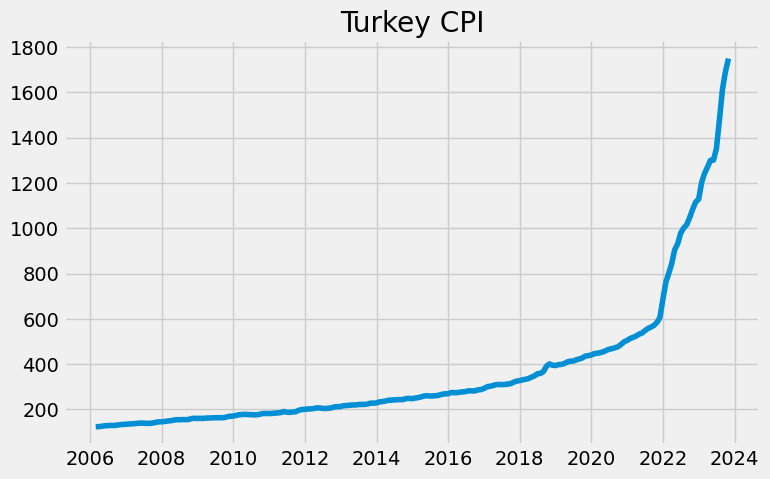

In [9]:
dates=pd.date_range('2006-02-01','2023-11-01' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)
plt.figure(figsize=(8,5))
plt.title("Turkey CPI")
plt.plot(df)
plt.show()


In [10]:
df6=pd.DataFrame()
df6["USD/TL"]=usd["TP_DK_USD_S_YTL"]

df6["USD/TL"]=df6["USD/TL"].astype(float)
df6

,USD/TL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.846114


In [11]:
money=evds.get_data(["TP.PR.ARZ13"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del money["Tarih"]
money=pd.DataFrame(money)
money.columns=["Para Arzi"]
money=money/1e+08
money=money.set_index(pd.date_range('2006-02-28','2023-12-29' , freq='1M'))
money

,Para Arzi
2006-02-28,2.423895
2006-03-31,2.494857
2006-04-30,2.521919
2006-05-31,2.751947
2006-06-30,2.791388
...,...
2023-07-31,114.784753
2023-08-31,120.253200
2023-09-30,123.493114
2023-10-31,127.637895


In [12]:
m3=evds.get_data(["TP.PR.ARZ22"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del m3["Tarih"]
m3.columns=["M3 Para Arzi"]
m3=m3/1e+08
m3=m3.set_index(money.index)
m3

,M3 Para Arzi
2006-02-28,2.663248
2006-03-31,2.731552
2006-04-30,2.767716
2006-05-31,3.025340
2006-06-30,3.038097
...,...
2023-07-31,117.729650
2023-08-31,123.434020
2023-09-30,126.660411
2023-10-31,130.933903


In [13]:

issizlik=evds.get_data(["TP.TIG08"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del issizlik["Tarih"]
issizlik.columns=["İşsizlik"]
issizlik=issizlik.dropna(axis=0)
issizlik=issizlik.set_index(pd.date_range(start="2014-01-30",end="2023-10-29",freq="1M"))
issizlik

,İşsizlik
2014-01-31,9.2
2014-02-28,9.5
2014-03-31,9.5
2014-04-30,9.7
2014-05-31,9.7
...,...
2023-05-31,9.5
2023-06-30,9.5
2023-07-31,9.3
2023-08-31,9.2


In [14]:
import yfinance as yf
df14=yf.download("BZ=F")["Close"]
df14=pd.DataFrame(df14)
df14.columns=["Brent"]
df14=df14.resample('M').mean()
df14

[*********************100%%**********************]  1 of 1 completed


,Brent
Date,
2007-07-31,76.395000
2007-08-31,71.258696
2007-09-30,77.135263
2007-10-31,82.456957
2007-11-30,92.060953
...,...
2023-08-31,85.104348
2023-09-30,92.766499
2023-10-31,88.704091


In [15]:
kredi=evds.get_data(["TP.KREDI.L001"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kredi

,Tarih,TP_KREDI_L001
0,2006-2,1.381847e+08
1,2006-3,1.481222e+08
2,2006-4,1.527510e+08
3,2006-5,1.664881e+08
4,2006-6,1.740395e+08
...,...,...
209,2023-7,9.846895e+09
210,2023-8,9.923806e+09
211,2023-9,1.025829e+10
212,2023-10,1.047935e+10


In [16]:
dates=pd.date_range('2006-02-01','2023-11-01' , freq='1M')
kredi=pd.DataFrame(kredi)
kredi.columns=["Tarih","Kredi"]
kredi["Kredi"]=kredi["Kredi"]/1e+08
kredi

,Tarih,Kredi
0,2006-2,1.381847
1,2006-3,1.481222
2,2006-4,1.527510
3,2006-5,1.664881
4,2006-6,1.740395
...,...,...
209,2023-7,98.468952
210,2023-8,99.238055
211,2023-9,102.582870
212,2023-10,104.793503


In [17]:
df3=pd.DataFrame()
df3["Kredi"]=kredi["Kredi"]
df3["TIME"]=pd.date_range(start="2006-02-28",periods=len(df3),freq="1M")
df3['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df3 = df3.set_index(['TIME'])
df3=df3.set_index(pd.date_range('2006-02-28','2023-12-29' , freq='1M'))
df3

,Kredi
2006-02-28,1.381847
2006-03-31,1.481222
2006-04-30,1.527510
2006-05-31,1.664881
2006-06-30,1.740395
...,...
2023-07-31,98.468952
2023-08-31,99.238055
2023-09-30,102.582870
2023-10-31,104.793503


In [18]:
pfaiz=evds.get_data(["TP.APIFON4"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
pfaiz.columns=["Tarih","Faiz"]
pfaiz.iloc[:11,1]=17.5
pfaiz.iloc[11:23,1]=21.5
pfaiz.iloc[23:35,1]=19.25
pfaiz.iloc[35:47,1]=10.25
pfaiz.iloc[47:59,1]=8
pfaiz["Faiz"]=pfaiz["Faiz"].astype(float)
#pfaiz.iloc[212,1]=35
pfaiz



,Tarih,Faiz
0,2006-2,17.50
1,2006-3,17.50
2,2006-4,17.50
3,2006-5,17.50
4,2006-6,17.50
...,...,...
210,2023-8,23.50
211,2023-9,31.00
212,2023-10,33.00
213,2023-11,41.09


In [19]:
dates=pd.date_range('2006-02-28','2024-01-29' , freq='1M')
pfaiz=pd.DataFrame(pfaiz)
pfaiz.columns=["Tarih","Politika Faizi"]
pfaiz["TIME"]=dates
pfaiz['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
pfaiz['TIME'] =  pd.to_datetime(pfaiz['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
pfaiz = pfaiz.set_index(['TIME'])
del pfaiz["Tarih"]
pfaiz

,Politika Faizi
TIME,
2006-02-28,17.50
2006-03-31,17.50
2006-04-30,17.50
2006-05-31,17.50
2006-06-30,17.50
...,...
2023-08-31,23.50
2023-09-30,31.00
2023-10-31,33.00


In [20]:
kfaiz=evds.get_data(["TP.KTFTUK"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kfaiz.columns=["Tarih","Kredi Faizi"]
kfaiz=kfaiz.set_index(kfaiz["Tarih"])
del kfaiz["Tarih"]
kfaiz=kfaiz.astype(float)
kfaiz=kfaiz.set_index(pd.date_range('2006-02-28','2023-12-29' , freq='1M'))
kfaiz

,Kredi Faizi
2006-02-28,17.2975
2006-03-31,17.0080
2006-04-30,16.2075
2006-05-31,16.3000
2006-06-30,19.6700
...,...
2023-07-31,45.8250
2023-08-31,45.7650
2023-09-30,56.3500
2023-10-31,59.3925


In [21]:
perakende=pd.read_excel("./perakende satis hacim endeksi ve degisim oranlari (sabit fiyatlarla) (2015=100) (2).xls")
perakende1=perakende.iloc[5:,2].dropna(axis=0).astype(float)
perakende1=pd.DataFrame(perakende1)
perakende1.columns=["Arındırılmamış"]


perakende1["Takvimden Arındırılmış"]=perakende.iloc[5:,4].astype(float)
perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]=perakende.iloc[5:,7].astype(float)
perakende1=perakende1.set_index(pd.date_range(start="2010-01-01",end="2023-10-01",freq="1M"))
perakende1

,Arındırılmamış,Takvimden Arındırılmış,Mevsimsellikten ve Takvimden Arındırılmış
2010-01-31,57.403841,57.747949,67.560585
2010-02-28,57.317027,57.179176,68.192727
2010-03-31,67.904361,67.034985,69.536955
2010-04-30,67.048510,66.458455,70.175625
2010-05-31,70.327428,70.614865,70.604236
...,...,...,...
2023-05-31,181.176925,179.718446,179.734862
2023-06-30,180.070938,186.170934,179.520633
2023-07-31,191.652101,194.140963,184.782561
2023-08-31,184.907520,183.148681,176.126980


In [22]:
motorin=pd.read_excel("./motorin.xlsx")
motorin.columns=["Tarih","Motorin"]
motorin=motorin.set_index(pd.date_range(start="2003-01-01",end="2023-12-01",freq="1M"))
del motorin["Tarih"]
motorin=motorin.astype(float)
motorin

,Motorin
2003-01-31,1.366645
2003-02-28,1.457199
2003-03-31,1.529555
2003-04-30,1.439813
2003-05-31,1.404363
...,...
2023-07-31,29.480000
2023-08-31,37.370000
2023-09-30,39.180000
2023-10-31,38.900000


In [23]:
sanayi=pd.read_excel("C:/Users/Bora/Downloads/sanayi uretim endeksi ve degisim oranlari (2015=100).xls")
sanayi=pd.DataFrame(sanayi.iloc[8:,5])
sanayi.columns=["Sanayi"]
sanayi=sanayi.set_index(pd.date_range(start="2005-02-08",periods=len(sanayi),freq="1M"))
sanayi=sanayi.dropna()
sanayi=sanayi.astype(float)
sanayi

,Sanayi
2005-02-28,57.747916
2005-03-31,57.058754
2005-04-30,57.685141
2005-05-31,58.226534
2005-06-30,58.022939
...,...
2023-05-31,146.666835
2023-06-30,148.351267
2023-07-31,147.798299
2023-08-31,146.674452


In [24]:
mfaiz=evds.get_data(["TP.TRY.MT02"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
mfaiz=mfaiz.set_index(pd.date_range(start="2006-02-01",end="2023-12-01",freq="1M"))
del mfaiz["Tarih"]
mfaiz.columns=["Mevduat Faizi"]
mfaiz

,Mevduat Faizi
2006-02-28,15.7600
2006-03-31,15.3300
2006-04-30,15.1750
2006-05-31,14.9250
2006-06-30,15.5840
...,...
2023-07-31,33.1250
2023-08-31,29.4125
2023-09-30,41.6560
2023-10-31,43.8925


In [25]:
from datetime import date
enf_belirsizlik=evds.get_data(["TP.BEK.S01.E.S"],startdate="30-06-2013",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
enf_belirsizlik=enf_belirsizlik.set_index(pd.date_range(start="2013-06-30",end="2023-12-29",freq="1M"))
del enf_belirsizlik["Tarih"]
enf_belirsizlik.columns=["Enflasyon Belirsizliği"]
enf_belirsizlik

,Enflasyon Belirsizliği
2013-06-30,0.62
2013-07-31,0.74
2013-08-31,0.74
2013-09-30,0.77
2013-10-31,0.65
...,...
2023-07-31,7.70
2023-08-31,6.81
2023-09-30,7.30
2023-10-31,5.57


In [26]:
borc=evds.get_data(["TP.KB.A09"],startdate="01-01-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del borc["Tarih"]
borc=borc.set_index(pd.date_range(start="2006-01-01",end="2023-11-29",freq="1M"))
borc.columns=["Borç"]
borc

,Borç
2006-01-31,2.435600e+08
2006-02-28,2.464270e+08
2006-03-31,2.463600e+08
2006-04-30,2.466640e+08
2006-05-31,2.507320e+08
...,...
2023-06-30,2.575631e+09
2023-07-31,2.643068e+09
2023-08-31,2.758965e+09
2023-09-30,2.859751e+09


In [27]:
redk=evds.get_data(["TP.RK.U01.Y"],startdate="31-03-2011",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del redk["Tarih"]
redk=redk.set_index(pd.date_range(start="2011-03-30",end="2023-11-29",freq="1M"))
redk.columns=["REDK"]
redk

,REDK
2011-03-31,105.42
2011-04-30,107.10
2011-05-31,103.79
2011-06-30,101.84
2011-07-31,98.49
...,...
2023-06-30,87.02
2023-07-31,81.68
2023-08-31,85.52
2023-09-30,89.55


In [28]:
redkt=evds.get_data(["TP.RK.T1.Y"],startdate="31-03-2011",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del redkt["Tarih"]
redkt=redkt.set_index(pd.date_range(start="2011-03-30",end="2023-11-29",freq="1M"))
redkt.columns=["REDKT"]
redkt

,REDKT
2011-03-31,111.62
2011-04-30,114.17
2011-05-31,112.89
2011-06-30,108.98
2011-07-31,104.82
...,...
2023-06-30,51.56
2023-07-31,48.68
2023-08-31,52.39
2023-09-30,55.46


In [32]:
data=pd.DataFrame()
data["USD/TL"]=df6["USD/TL"][:-1].rolling(3).mean()
data["ParaArzi"]=money["Para Arzi"].shift(1)
data["Motorin"]=motorin["Motorin"]
data["Perakende Satış"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]
data["Sanayi"]=sanayi["Sanayi"]
data["Kredi"]=df3["Kredi"].rolling(2).mean()
data["M3"]=m3["M3 Para Arzi"].shift(1)
data["REDK"]=redk["REDK"]
data["REDKT"]=redkt["REDKT"]
data["Borç"]=(borc["Borç"]/1e+08).shift(1)
data["TÜFE"]=df["CPI"]
data=data.pct_change(periods=1)*100
data=data.dropna(axis=0)
data

,USD/TL,ParaArzi,Motorin,Perakende Satış,Sanayi,Kredi,M3,REDK,REDKT,Borç,TÜFE
Tarih,,,,,,,,,,,
2011-04-30,-0.810542,1.738088,-1.218711,-0.176965,-0.162949,2.978727,1.642254,1.593625,2.284537,0.684613,0.866270
2011-05-31,-0.399628,0.113812,-1.660706,1.110822,1.016932,3.568114,0.477281,-3.090570,-1.121135,0.570506,2.420827
2011-06-30,0.415548,2.361933,2.055258,2.490629,1.895703,3.122424,2.450559,-1.878794,-3.463549,0.194110,-1.430743
2011-07-31,2.804715,2.187652,2.237631,1.258223,1.925345,2.898935,2.189939,-3.289474,-3.817214,0.019793,-0.409400
2011-08-31,3.747733,0.569285,1.664460,-0.296514,2.983648,3.279260,0.444077,-4.213626,-5.533295,0.318355,0.726069
...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31,11.475241,15.146856,33.393665,2.931099,-0.372743,5.675617,15.439600,-6.136520,-5.585725,9.689321,9.488824
2023-08-31,10.505114,5.943431,26.763908,-4.684198,-0.760392,1.850455,5.968276,4.701273,7.621200,2.618269,9.086793
2023-09-30,5.071342,4.764088,4.843457,-0.712124,-0.125062,2.080815,4.845313,4.712348,5.859897,4.384930,4.753114


In [33]:

data["Enflasyon Belirsizliği"]=enf_belirsizlik
data["Kredi Faizi"]=kfaiz["Kredi Faizi"]
data["Mevduat Faizi"]=mfaiz["Mevduat Faizi"]
data["Zam"]=0
data["Politika Faizi"]=pfaiz["Politika Faizi"]
data["İşsizlik"]=issizlik["İşsizlik"]
yearly_mean = data.groupby(data.index.year)['TÜFE'].mean()
data['Şok'] = (data.index.year.map(yearly_mean) < data['TÜFE']).astype(int)
yearly_mean = data.groupby(data.index.year)['TÜFE'].mean()
data=data.dropna(axis=0)
data=data[['USD/TL', 'Motorin', 'Perakende Satış', 'Kredi Faizi','Zam', 'Sanayi', 'Enflasyon Belirsizliği','ParaArzi','Borç','Kredi','Mevduat Faizi','Şok','REDK','REDKT','M3','İşsizlik','Politika Faizi',"TÜFE"]]
data.iloc[0,4]=11.01
data.iloc[12,4]=12.3
data.iloc[24,4]=29.32
data.iloc[36,4]=7.92
data.iloc[48,4]=14.17
data.iloc[60,4]=25.45
data.iloc[72,4]=15
data.iloc[84,4]=26.56
data.iloc[96,4]=50
data.iloc[102,4]=30
data.iloc[108,4]=54
data.iloc[114,4]=34
data

,USD/TL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,Şok,REDK,REDKT,M3,İşsizlik,Politika Faizi,TÜFE
Tarih,,,,,,,,,,,,,,,,,,
2014-01-31,3.732429,2.881984,3.944616,13.5140,11.01,3.604096,0.82,3.375162,-0.584687,3.267877,9.0220,1,-3.691204,-5.094658,3.413428,9.2,9.96,1.978080
2014-02-28,3.033477,1.685899,-4.487196,15.4575,0.00,-0.850238,0.73,1.804994,0.808574,1.451593,10.6275,0,2.179150,0.919060,2.079333,9.5,10.23,0.428192
2014-03-31,2.465778,-2.278097,-0.070420,15.8900,0.00,0.128936,0.80,0.451349,0.193691,0.341852,11.3125,1,0.471546,0.641623,0.229599,9.5,10.27,1.125608
2014-04-30,-1.344724,-6.214384,-0.769499,15.8625,0.00,-0.863760,0.73,0.796760,0.478162,0.129671,11.0200,1,4.682667,5.892031,0.730196,9.7,10.03,1.344970
2014-05-31,-1.859714,-0.561578,0.433585,15.4280,0.00,-1.367417,0.80,-0.362357,0.091080,0.468727,10.4940,0,1.283880,2.058652,-0.093468,9.7,9.53,0.395224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31,1.507585,-7.526882,3.200118,32.0225,0.00,1.434427,7.37,4.931112,2.663712,3.535416,31.4625,0,1.004595,-1.762413,4.796282,9.5,9.09,0.043076
2023-06-30,7.066073,16.807611,-0.119192,38.5600,0.00,1.148476,7.55,-1.017069,2.406884,5.711697,39.5920,0,-7.925087,-11.057444,-1.142443,9.5,12.84,3.920498
2023-07-31,11.475241,33.393665,2.931099,45.8250,34.00,-0.372743,7.70,15.146856,9.689321,5.675617,33.1250,1,-6.136520,-5.585725,15.439600,9.3,17.50,9.488824


In [715]:
features=["USD/TL","Motorin","Enflasyon Belirsizliği","ParaArzi","Kredi Faizi","TÜFE"]
train=data[features].iloc[:-3,:]
test=data[features].iloc[-3:,:]


In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

In [877]:
test_period = 3 # Son 3 ayı test olarak ayırın
test_size = test_period   # Her ay 30 gün olarak kabul ederek hesaplayın

train_data = data[:-test_size]
test_data = data[-test_size:]

# Bağımsız değişkenleri ve TÜFE'yi ayırın
X_train = train.drop(['TÜFE'], axis=1).values
y_train = train['TÜFE'].values
X_test = test.drop(['TÜFE'], axis=1).values
y_test = test['TÜFE'].values

In [313]:
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(1)

In [878]:
import tensorflow as tf
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, activation='elu', input_shape=(X_train_scaled.shape[1],1)))
model.add(tf.keras.layers.Dense(64,activation='selu'))
model.add(tf.keras.layers.Dense(64,activation='elu')) # 1, çünkü tek bir özellik kullanıyoruz
model.add(tf.keras.layers.Dense(1))
rms = optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer=rms, loss='mean_squared_error')


early_stopping = EarlyStopping(patience=25, restore_best_weights=True)

model.fit(X_train_scaled, y_train_scaled, epochs=500, batch_size=32, validation_data=(X_test_scaled, y_test_scaled),callbacks=[early_stopping])


Epoch 1/500
4/4 [==============================] - 2s 95ms/step - loss: 3.4695 - val_loss: 0.9421
Epoch 2/500
4/4 [==============================] - 0s 19ms/step - loss: 0.1162 - val_loss: 0.2036
Epoch 3/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0172 - val_loss: 0.1657
Epoch 4/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0175 - val_loss: 0.1332
Epoch 5/500
4/4 [==============================] - 0s 18ms/step - loss: 0.0163 - val_loss: 0.1609
Epoch 6/500
4/4 [==============================] - 0s 18ms/step - loss: 0.0157 - val_loss: 0.1447
Epoch 7/500
4/4 [==============================] - 0s 18ms/step - loss: 0.0140 - val_loss: 0.0928
Epoch 8/500
4/4 [==============================] - 0s 18ms/step - loss: 0.0119 - val_loss: 0.0580
Epoch 9/500
4/4 [==============================] - 0s 18ms/step - loss: 0.0168 - val_loss: 0.3317
Epoch 10/500
4/4 [==============================] - 0s 18ms/step - loss: 0.1008 - val_loss: 0.1103
Epoch 11/500
4/4 [=

In [393]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import ParameterGrid

# Verileri ve etiketleri yükleyin (X_train, X_test, y_train, y_test olarak varsayalım)

# Model fonksiyonunu tanımlayın
def create_model(neurons=128, activation='relu', optimizer='adam', epochs=100):
    model = Sequential()
    model.add(LSTM(neurons, activation=activation, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    early_stopping = EarlyStopping(patience=25, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, verbose=0, validation_data=(X_test_scaled, y_test_scaled),callbacks=[early_stopping])
    return model


# Grid Search için hiperparametre kombinasyonlarını tanımlayın
param_grid = {
    'neurons': [64, 128],
    'activation': ['relu', 'tanh','selu','sigmoid','elu','gelu','linear'],
    'optimizer': ['adam', 'rmsprop','Adadelta','Adagrad','Adamax','Nadam','Ftrl'],
    'epochs': [500]
}

best_rmse = float('inf')
best_params = None

# Grid Search yapın
for params in ParameterGrid(param_grid):
    model = create_model(neurons=params['neurons'], activation=params['activation'], optimizer=params['optimizer'], epochs=params['epochs'])
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test_scaled, y_pred)
    rmse = np.sqrt(mse)
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

# En iyi hiperparametreleri ve sonuçları görüntüleyin
print("En iyi RMSE:", best_rmse)
print("En iyi parametreler:", best_params)


1/1 [==============================] - 0s 193ms/step
En iyi RMSE: 0.08123241780723583
En iyi parametreler: {'activation': 'tanh', 'epochs': 500, 'neurons': 64, 'optimizer': 'Nadam'}


In [890]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Modelinizi eğittikten sonra tahminlerinizi yapın
y_pred = model.predict(X_test_scaled)

# Tahminleri gerçek değerlerle karşılaştırarak MSE hesaplayın
mse = mean_squared_error(y_test_scaled, y_pred)
rmse = np.sqrt(mse)

print(f"Validation MSE: {mse}")
print(f"Validation RMSE: {rmse}")


1/1 [==============================] - 0s 24ms/step
Validation MSE: 0.0022147232062144327
Validation RMSE: 0.04706084578728301


In [942]:
X = data.drop(['TÜFE'], axis=1).values
y = data['TÜFE'].values
X=data[['USD/TL',
 'Motorin',
 'Enflasyon Belirsizliği',
 'ParaArzi',
 'Kredi Faizi','REDKT','REDK']].values

X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, activation='elu', input_shape=(7,1)))
model.add(tf.keras.layers.Dense(64,activation='selu'))
model.add(tf.keras.layers.Dense(64,activation='elu')) # 1, çünkü tek bir özellik kullanıyoruz
model.add(tf.keras.layers.Dense(1))
rms = optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer=rms, loss='mean_squared_error')




model.fit(X_scaled, y_scaled, epochs=100, batch_size=32)

Epoch 1/100
4/4 [==============================] - 2s 11ms/step - loss: 4.0809
Epoch 2/100
4/4 [==============================] - 0s 11ms/step - loss: 0.1370
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0206
Epoch 4/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0195
Epoch 5/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0290
Epoch 6/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0172
Epoch 7/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0522
Epoch 8/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0588
Epoch 9/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0218
Epoch 10/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0173
Epoch 11/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0757
Epoch 12/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0724
Epoch 13/100
4/4 [==============================]

In [943]:
tahmin=tahmindf[['USD/TL',
 'Motorin',
 'Enflasyon Belirsizliği',
 'ParaArzi',
 'Kredi Faizi','REDKT','REDK']].values
X_scaled = scaler.fit_transform(X)
tahmin_scaled = scaler.transform(tahmin)

In [945]:

pred = model.predict(tahmin_scaled)
y_scaled = scaler.fit_transform(y.reshape(-1, 1))
pred = scaler.inverse_transform(pred)
pred



1/1 [==============================] - 0s 31ms/step


array([[2.2159781],
       [2.254879 ],
       [3.901162 ],
       [2.411607 ],
       [2.6803572],
       [4.5778027],
       [3.734642 ],
       [2.6627374],
       [2.5356333],
       [2.5992336],
       [3.3058481],
       [2.3897655],
       [2.3633957],
       [2.8663604],
       [1.7875464]], dtype=float32)

In [903]:
y_pred_original_scale = scaler.inverse_transform(y_pred)

# Tahmin edilen değerleri inceleyin
np.sqrt(mean_squared_error(y_test,y_pred_original_scale))

0.7067791298260985

In [266]:
y_test

array([9.48882427, 9.08679317, 4.75311433])

In [904]:
y_pred_original_scale

array([[9.542083 ],
       [7.864648 ],
       [4.7069125]], dtype=float32)

In [74]:
y_test

array([10.5051144 ,  5.07134153])

In [36]:
cor_matrix=data.corr()
cor_matrix["TÜFE"].sort_values(ascending=False)

TÜFE                      1.000000
USD/TL                    0.724721
Motorin                   0.718312
ParaArzi                  0.678612
M3                        0.670119
Enflasyon Belirsizliği    0.622137
Kredi Faizi               0.531337
Kredi                     0.520359
Şok                       0.449432
Borç                      0.447182
Mevduat Faizi             0.441591
Zam                       0.410035
Politika Faizi            0.215310
REDK                     -0.000213
REDKT                    -0.024862
Sanayi                   -0.047965
Perakende Satış          -0.116436
İşsizlik                 -0.187390
Name: TÜFE, dtype: float64

In [30]:
data.to_csv("data.csv")

In [31]:
'''from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
features=data.iloc[:,:-1].columns
train=data.iloc[:-3,:]
test=data.iloc[-3:,:]
X_train,X_test,y_train,y_test=train.iloc[:,:-1],test.iloc[:,:-1],train.iloc[:,-1],test.iloc[:,-1]
best_mse=float("inf")
best_features=[]
for r in range(8,12):
   for combo in combinations(features, r):
        selected_features = list(combo)
        
          
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]
        krr = KernelRidge(alpha=1.0)
        krr.fit(X_train_subset, y_train)
        y_pred=krr.predict(X_test_subset)
        rmse1=np.sqrt(mean_squared_error(y_test,y_pred))
        

        
        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin
        if rmse1 < best_mse:
            best_mse = rmse1
            best_features = selected_features
            

# En iyi özellik kombinasyonu ve MSE değeri
print("En iyi özellik kombinasyonu:")
print(best_features)
print("En iyi RMSE değeri:", best_mse)'''

'from sklearn.cross_decomposition import PLSRegression\nfrom sklearn.svm import SVR\nfrom sklearn.preprocessing import PolynomialFeatures\nfrom sklearn.pipeline import make_pipeline\nfeatures=data.iloc[:,:-1].columns\ntrain=data.iloc[:-3,:]\ntest=data.iloc[-3:,:]\nX_train,X_test,y_train,y_test=train.iloc[:,:-1],test.iloc[:,:-1],train.iloc[:,-1],test.iloc[:,-1]\nbest_mse=float("inf")\nbest_features=[]\nfor r in range(8,12):\n   for combo in combinations(features, r):\n        selected_features = list(combo)\n        \n          \n        X_train_subset = X_train[selected_features]\n        X_test_subset = X_test[selected_features]\n        krr = KernelRidge(alpha=1.0)\n        krr.fit(X_train_subset, y_train)\n        y_pred=krr.predict(X_test_subset)\n        rmse1=np.sqrt(mean_squared_error(y_test,y_pred))\n        \n\n        \n        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin\n        if rmse1 < best_mse:\n            best_mse = rmse1\n            best_features = s

In [32]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")
features=['USD/TL', 'Motorin', 'Kredi Faizi', 'Sanayi', 'Enflasyon Belirsizliği', 'Mevduat Faizi', 'REDK', 'REDKT']
X = data[features]
X = sm.add_constant(X)
y=data[["TÜFE"]]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
model = sm.OLS(y, X).fit()
rmse=[]
tahminler=pd.DataFrame()
tahminler["Aylık Enflasyon"]=y_test
tahminler["Linear Regression"]=model.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Linear Regression"])))


In [33]:
from sklearn import linear_model
from sklearn.metrics import  mean_squared_error
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Zam', 'Enflasyon Belirsizliği', 'Kredi', 'REDK', 'REDKT', 'İşsizlik', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)

tahminler["Bayesian Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Bayesian Regression"])))


In [34]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USD/TL', 'Motorin', 'Sanayi', 'Mevduat Faizi', 'REDK', 'REDKT', 'İşsizlik', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]

reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train,y_train)

tahminler["Lasso Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lasso Regression"])))

In [35]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USD/TL', 'Motorin', 'Perakende Satış', 'Sanayi', 'Mevduat Faizi', 'REDK', 'REDKT', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X_train, y_train)

tahminler["SGD Regressor"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["SGD Regressor"])))

In [36]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USD/TL', 'Motorin', 'Perakende Satış', 'ParaArzi', 'Kredi', 'Şok', 'REDK', 'REDKT']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = linear_model.Lars(random_state=0)
reg.fit(X_train,y_train)

tahminler["Lars Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lars Regression"])))

In [37]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Zam', 'Enflasyon Belirsizliği', 'Kredi', 'REDK', 'REDKT', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(X_train, y_train) 
        

        



tahminler["Gaussian Regression"]=gpr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Gaussian Regression"])))



In [38]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Enflasyon Belirsizliği', 'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
krr = KernelRidge(alpha=1.0)
krr.fit(X_train, y_train)
        

        



tahminler["Kernel Regression"]=krr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Kernel Regression"])))



In [39]:
rmse_df=pd.DataFrame(rmse,index=[tahminler.columns[1:]])
rmse_df.columns=["RMSE"]
rmse_df=rmse_df.sort_values(by="RMSE")
rmse_df

,RMSE
Lars Regression,0.072823
Linear Regression,0.080919
SGD Regressor,0.215809
Lasso Regression,0.237855
Gaussian Regression,0.700413
Bayesian Regression,0.775546
Kernel Regression,0.827823


<Figure size 500x1000 with 0 Axes>

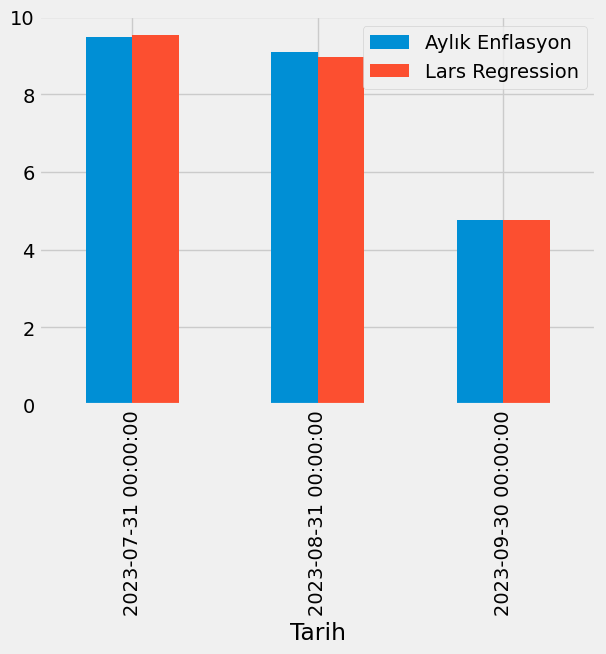

In [40]:
plt.figure(figsize=(5,10))
tahminler["Ortalama"]=tahminler.iloc[:,1:].mean(axis=1)
tahminler[["Aylık Enflasyon","Lars Regression"]].plot(kind="bar")
plt.show()

In [600]:
model=auto_arima(kfaiz["Kredi Faizi"],seasonal=True,m=9)
model_fit = model.fit(kfaiz["Kredi Faizi"])

forecast = model_fit.predict(26)
kfaiztahmin=pd.DataFrame(forecast)
kfaiztahmin.columns=["Kredi Faizi"]
new_row=pd.DataFrame({"Kredi Faizi":kfaiz.iloc[210:,0]},index=pd.date_range(start="2023-08-30",end="2023-12-29",freq="1M"))
kfaiztahmin=pd.concat([new_row,kfaiztahmin],axis=0)
kfaiztahmin



,Kredi Faizi
2023-08-31,45.765000
2023-09-30,56.350000
2023-10-31,59.392500
2023-11-30,58.655000
2023-12-31,58.050804
2024-01-31,58.243736
2024-02-29,58.551302
2024-03-31,59.409785
2024-04-30,60.386403
2024-05-31,60.370085


In [601]:
trainexog=kfaiz[47:-2]
trainexog

,Kredi Faizi
2010-01-31,13.7920
2010-02-28,13.5200
2010-03-31,13.5125
2010-04-30,13.0040
2010-05-31,13.1525
...,...
2023-05-31,32.0225
2023-06-30,38.5600
2023-07-31,45.8250
2023-08-31,45.7650


In [602]:
testexog=kfaiztahmin[2:]
testexog

,Kredi Faizi
2023-10-31,59.392500
2023-11-30,58.655000
2023-12-31,58.050804
2024-01-31,58.243736
2024-02-29,58.551302
2024-03-31,59.409785
2024-04-30,60.386403
2024-05-31,60.370085
2024-06-30,61.813906
2024-07-31,62.228177


In [603]:
mfaiz[189:]

,Mevduat Faizi
2021-11-30,16.2025
2021-12-31,17.4400
2022-01-31,19.2675
2022-02-28,18.1100
2022-03-31,17.1350
2022-04-30,17.0840
2022-05-31,16.9900
2022-06-30,18.2250
2022-07-31,19.7920
2022-08-31,19.2050


In [604]:
model=auto_arima(mfaiz["Mevduat Faizi"][189:],trace=False,seasonal=False,information_criterion="aic")
mfaiztahmin=pd.DataFrame(model.predict(25))
mfaiztahmin.columns=["Mevduat Faizi"]
row=pd.DataFrame({"Mevduat Faizi":mfaiz.iloc[-1,0]},index=pd.date_range(start="2023-11-30",periods=1,freq="1M"))
mfaiztahmin=pd.concat([row,mfaiztahmin],axis=0)
mfaiztahmin


,Mevduat Faizi
2023-11-30,45.667500
2023-12-31,46.895208
2024-01-31,48.122917
2024-02-29,49.350625
2024-03-31,50.578333
2024-04-30,51.806042
2024-05-31,53.033750
2024-06-30,54.261458
2024-07-31,55.489167
2024-08-31,56.716875


In [605]:
trainexog=pd.DataFrame()
trainexog["Dolar"]=usd.iloc[:-6,0].rolling(2).mean().dropna()*df14.iloc[:-6,0]
trainexog=trainexog.dropna()
trainexog=np.array(trainexog).reshape(-1,1)
testexog=pd.DataFrame()
testexog["Dolar"]=usd.iloc[-7:,0].rolling(2).mean().dropna()*df14.iloc[-6:,0]
testexog=testexog.dropna()
testexog=np.array(testexog).reshape(-1,1)

In [606]:
exog=pd.DataFrame()
exog["X"]=usd["TP_DK_USD_S_YTL"].rolling(2).mean().dropna()*df14["Brent"]
exog=exog.dropna()
exog
#exog=np.array(exog).reshape(-1,1)


,X
2007-07-31,99.454046
2007-08-31,92.519699
2007-09-30,99.580871
2007-10-31,101.824103
2007-11-30,110.143119
...,...
2023-08-31,2275.241982
2023-09-30,2504.165548
2023-10-31,2432.069312
2023-11-30,2316.594077


In [607]:

zamtahmin=pd.DataFrame()
zamtahmin["Zam"]=[0,00,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0]
zamtahmin.columns=["Zam"]
zamtahmin=zamtahmin.set_index(pd.date_range(start="2023-08-30",end="2026-01-27",freq="1M"))
zamtahmin

,Zam
2023-08-31,0
2023-09-30,0
2023-10-31,0
2023-11-30,0
2023-12-31,0
2024-01-31,45
2024-02-29,0
2024-03-31,0
2024-04-30,0
2024-05-31,0


In [608]:
model=auto_arima(pfaiz["Politika Faizi"][144:],seasonal=False,information_criterion="bic")
model_fit = model.fit(pfaiz["Politika Faizi"])
faiztahmin = model_fit.predict(26)
faiztahmin=pd.DataFrame(faiztahmin)
faiztahmin.columns=["Politika Faizi"]
row=pd.DataFrame({"Politika Faizi":pfaiz.iloc[210:,0]},index=pd.date_range(start="2023-08-30",end="2023-12-29",freq="1M"))
faiztahmin=pd.concat([row,faiztahmin],axis=0)
faiztahmin

,Politika Faizi
2023-08-31,23.500000
2023-09-30,31.000000
2023-10-31,33.000000
2023-11-30,41.090000
2024-01-31,42.737497
2024-02-29,43.099763
2024-03-31,42.746171
2024-04-30,41.815902
2024-05-31,40.435651
2024-06-30,38.719051


In [609]:
faiztahmin.columns=["Faiz"]


In [610]:
exogtrain=pd.DataFrame()
exogtrain["Faiz"]=pfaiz["Politika Faizi"].iloc[95:-14]
exogtrain=np.array(exogtrain).reshape(-1,1)

exogtest=pd.DataFrame()
exogtest=pd.concat([pfaiz["Politika Faizi"].iloc[-14:-2],faiztahmin.iloc[2:,0]],axis=0)
exogtest=np.array(exogtest).reshape(-1,1)



In [611]:
exog=pfaiz["Politika Faizi"].iloc[95:-3]
exog=np.array(exog).reshape(-1,1)

In [612]:
exogtest=faiztahmin.iloc[2:]
exogtest=np.array(exogtest).reshape(-1,1)

In [613]:
model=auto_arima(issizlik,seasonal=True,m=3,X=exog)
model_fit = model.fit(issizlik,X=exog)
issizliktahmin = model_fit.predict(28,X=exogtest)
issizliktahmin=pd.DataFrame(issizliktahmin)
issizliktahmin.columns=["İşsizlik"]
issizliktahmin

,İşsizlik
2023-10-31,9.086846
2023-11-30,9.020789
2023-12-31,9.047010
2024-01-31,9.091588
2024-02-29,9.152629
2024-03-31,9.220321
2024-04-30,9.292262
2024-05-31,9.368708
2024-06-30,9.446114
2024-07-31,9.523187


In [614]:
from prophet import Prophet


In [615]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'm':trial.suggest_int('m',10,200)
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df6[params["m"]:-12].index
    sn["y"]=df6[params["m"]:-12].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth="linear")
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(df6[-12:].values,predictions["yhat"][-12:].values)
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'m\':trial.suggest_int(\'m\',10,200)\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df6[params["m"]:-12].index\n    sn["y"]=df6[params["m"]:-12].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth="linear")\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=12,freq="M")\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(df6[-12:].values,predictions["yhat"][-12:].values)\n    return mae_score\nstudy = optuna.crea

In [616]:
sn=pd.DataFrame()
sn["ds"]=df6[50:].index
sn["y"]=df6[50:].values
sn["cap"]=80
prophet=Prophet(growth="logistic",changepoint_prior_scale=4.824871754400055,changepoint_range=0.8753050513666666)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
future_dates["cap"]=80
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:Adding TBB (c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\stan_model\cmdstan-2.33.1\stan\lib\stan_math\lib\tbb) to PATH
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Bora\AppData\Local\Temp\tmpl87r6lfv\7mb7slfz.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Bora\AppData\Local\Temp\tmpl87r6lfv\ccsu7ora.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Bora\\AppData\\Local\\Programs\\Python\\Python310\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=23536', 'data', 'file=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\7mb7slfz.json', 'init=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\ccsu7

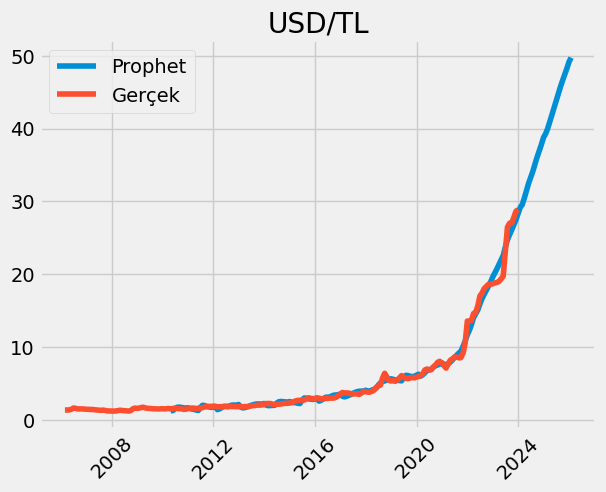

In [617]:
plt.title("USD/TL")
plt.plot(predictions["yhat"],label="Prophet")
plt.plot(df6["USD/TL"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [618]:
usdtahmin=(predictions["yhat"][-27:].pct_change(periods=1)*100).dropna()
usdtahmin

ds
2023-12-31    3.107324
2024-01-31    2.962183
2024-02-29    1.358602
2024-03-31    3.128048
2024-04-30    3.269917
2024-05-31    3.238486
2024-06-30    2.535270
2024-07-31    2.465240
2024-08-31    2.984947
2024-09-30    2.619686
2024-10-31    2.415423
2024-11-30    2.315545
2024-12-31    2.553203
2025-01-31    1.352456
2025-02-28    1.758805
2025-03-31    2.329789
2025-04-30    2.308712
2025-05-31    2.320694
2025-06-30    2.299650
2025-07-31    2.165584
2025-08-31    2.138090
2025-09-30    1.857302
2025-10-31    1.779857
2025-11-30    1.696752
2025-12-31    1.893999
2026-01-31    1.228044
Name: yhat, dtype: float64

In [619]:
usdtahmin1 = []
result = df6.iloc[-1,0]
for i in range(len(usdtahmin)):
    result *= (1 + usdtahmin[i] / 100)
    usdtahmin1.append(result)

usdtahmin1 = np.array(usdtahmin1).reshape(-1, 1)
usdtahmin1 = pd.DataFrame(usdtahmin1)
usdtahmin1.columns = ["USD/TL"]
usdtahmin1=pd.concat([df6.iloc[-5:-1],usdtahmin1],axis=0)
usdtahmin1 = usdtahmin1.set_index(pd.date_range(start="2023-08-30", end="2026-02-27", freq="1M"))
usdtahmin1

,USD/TL
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.846114
2023-11-30,28.637082
2023-12-31,29.769971
2024-01-31,30.651813
2024-02-29,31.068249
2024-03-31,32.040079
2024-04-30,33.087763
2024-05-31,34.159305


In [620]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df14[100:].index
    sn["y"]=df14[100:].values
    sn["cap"]=1000
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=27,freq="M")
    future_dates["cap"]=1000
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df14[100:].index\n    sn["y"]=df14[100:].values\n    sn["cap"]=1000\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=27,freq="M")\n    future_dates["cap"]=1000\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=1000)'

In [621]:
#study.best_params

In [622]:
sn=pd.DataFrame()
sn["ds"]=df14[100:].index
sn["y"]=df14[100:].values
sn["cap"]=500
prophet=Prophet(growth="linear",changepoint_prior_scale=4.999468721964881,changepoint_range=0.8755786334851338)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=500
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Bora\AppData\Local\Temp\tmpl87r6lfv\55y8s3hd.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Bora\AppData\Local\Temp\tmpl87r6lfv\mdgdfgpl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Bora\\AppData\\Local\\Programs\\Python\\Python310\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=60935', 'data', 'file=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\55y8s3hd.json', 'init=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\mdgdfgpl.json', 'output', 'file=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\prophet_modelrd87n7en\\prophet_model-2023120

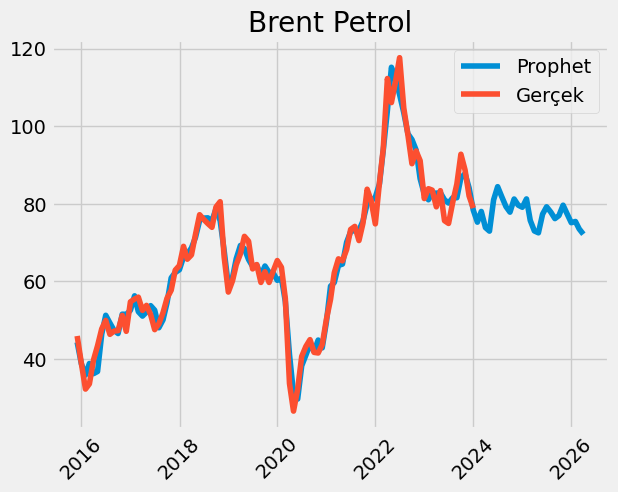

In [623]:
plt.title("Brent Petrol")
plt.plot(predictions["yhat"],label="Prophet")
plt.plot(df14["Brent"][100:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [624]:
brenttahmin=(predictions["yhat"][-28:].pct_change(periods=1)*100).dropna()
brenttahmin

ds
2024-01-31    -3.995260
2024-02-29     3.666242
2024-03-31    -5.320071
2024-04-30    -1.248621
2024-05-31    11.087530
2024-06-30     4.168818
2024-07-31    -3.098798
2024-08-31    -3.081825
2024-09-30    -1.814139
2024-10-31     4.364683
2024-11-30    -1.951160
2024-12-31    -0.688616
2025-01-31     2.719590
2025-02-28    -6.799971
2025-03-31    -3.614216
2025-04-30    -0.655568
2025-05-31     6.630997
2025-06-30     2.456350
2025-07-31    -1.703148
2025-08-31    -2.178659
2025-09-30     1.032981
2025-10-31     3.483210
2025-11-30    -2.816354
2025-12-31    -2.935724
2026-01-31     0.414527
2026-02-28    -2.542777
2026-03-31    -1.862541
Name: yhat, dtype: float64

In [625]:
df14.iloc[-1]

Brent    78.879997
Name: 2023-12-31 00:00:00, dtype: float64

In [626]:
brenttahmin1 = []
result = df14.iloc[-1,0]
for i in range(len(brenttahmin)):
    result *= (1 + brenttahmin[i] / 100)
    brenttahmin1.append(result)

brenttahmin1 = np.array(brenttahmin1).reshape(-1, 1)
brenttahmin1 = pd.DataFrame(brenttahmin1)
brenttahmin1.columns = ["Brent"]
brenttahmin1 = brenttahmin1.set_index(pd.date_range(start="2024-01-30", end="2026-04-27", freq="1M"))
row=pd.DataFrame({"Brent":df14.iloc[-3:,0]},index=pd.date_range("2023-10-30",periods=2,freq="1M"))
brenttahmin1=pd.concat([row,brenttahmin1],axis=0)
brenttahmin1

,Brent
2023-10-31,88.704091
2023-11-30,82.027727
2024-01-31,75.728536
2024-02-29,78.504927
2024-03-31,74.328409
2024-04-30,73.400329
2024-05-31,81.538613
2024-06-30,84.937809
2024-07-31,82.305758
2024-08-31,79.769239


In [627]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=enf_belirsizlik.index
    sn["y"]=enf_belirsizlik.values
    sn["cap"]=100
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=27,freq="M")
    future_dates["cap"]=100
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=enf_belirsizlik.index\n    sn["y"]=enf_belirsizlik.values\n    sn["cap"]=100\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=27,freq="M")\n    future_dates["cap"]=100\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=1000)'

In [628]:
#study.best_params

In [629]:
sn=pd.DataFrame()
sn["ds"]=enf_belirsizlik.index
sn["y"]=enf_belirsizlik.values
sn["cap"]=100
prophet=Prophet(changepoint_prior_scale=4.9990034924644275,changepoint_range=0.899334568997575,growth='linear')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=100
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Bora\AppData\Local\Temp\tmpl87r6lfv\_riav6ea.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Bora\AppData\Local\Temp\tmpl87r6lfv\20y47llv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Bora\\AppData\\Local\\Programs\\Python\\Python310\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=59531', 'data', 'file=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\_riav6ea.json', 'init=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\20y47llv.json', 'output', 'file=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\prophet_model372gegli\\prophet_model-2023120

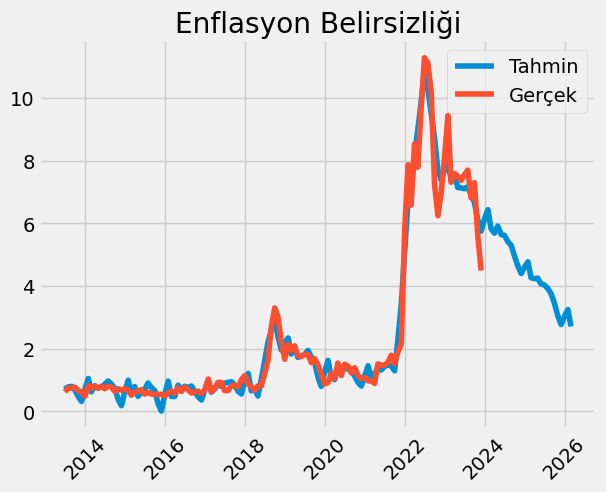

In [630]:
plt.title("Enflasyon Belirsizliği")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(enf_belirsizlik["Enflasyon Belirsizliği"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [631]:
enfbelirsizliktahmin=(predictions["yhat"][-28:].pct_change(periods=1)*100).dropna()
enfbelirsizliktahmin

ds
2023-12-31     6.953347
2024-01-31     4.726997
2024-02-29    -9.552151
2024-03-31    -2.312712
2024-04-30     4.034606
2024-05-31    -4.604811
2024-06-30    -0.478931
2024-07-31    -3.538186
2024-08-31    -2.265246
2024-09-30    -6.425931
2024-10-31    -6.548229
2024-11-30    -5.019494
2024-12-31     4.654556
2025-01-31     3.666030
2025-02-28   -10.624290
2025-03-31    -0.724876
2025-04-30     0.362321
2025-05-31    -4.422187
2025-06-30    -0.710613
2025-07-31    -2.719679
2025-08-31    -4.438113
2025-09-30    -8.031677
2025-10-31   -11.645712
2025-11-30    -9.110944
2025-12-31     9.693603
2026-01-31     6.928056
2026-02-28   -16.593937
Name: yhat, dtype: float64

In [632]:
enfbelirsizliktahmin1 = []
result = enf_belirsizlik.iloc[-1,0]
for i in range(len(enfbelirsizliktahmin)):
    result *= (1 + enfbelirsizliktahmin[i] / 100)
    enfbelirsizliktahmin1.append(result)

enfbelirsizliktahmin1 = np.array(enfbelirsizliktahmin1).reshape(-1, 1)
enfbelirsizliktahmin1 = pd.DataFrame(enfbelirsizliktahmin1)
enfbelirsizliktahmin1.columns = ["Enflasyon Belirsizliği"]
enfbelirsizliktahmin1 = enfbelirsizliktahmin1.set_index(pd.date_range(start="2023-12-30", end="2026-03-27", freq="1M"))
row=pd.DataFrame({"Enflasyon Belirsizliği":enf_belirsizlik.iloc[-2:,0]},index=pd.date_range(start="2023-10-30",periods=2,freq="1M"))
enfbelirsizliktahmin1=pd.concat([row,enfbelirsizliktahmin1],axis=0)
enfbelirsizliktahmin1

,Enflasyon Belirsizliği
2023-10-31,5.570000
2023-11-30,4.490000
2023-12-31,4.802205
2024-01-31,5.029205
2024-02-29,4.548808
2024-03-31,4.443607
2024-04-30,4.622889
2024-05-31,4.410014
2024-06-30,4.388893
2024-07-31,4.233606


In [633]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][71:].index
    sn["y"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][71:].values
    sn["cap"]=100
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=51,freq="M")
    future_dates["cap"]=100
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-51))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][71:].index\n    sn["y"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][71:].values\n    sn["cap"]=100\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=51,freq="M")\n    future_dates["cap"]=100\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-51))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nst

In [634]:
#study.best_params

In [635]:
sn=pd.DataFrame()
sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][100:].index
sn["y"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][100:].values
sn["cap"]=1000
prophet=Prophet(changepoint_prior_scale=4.9993655900615845,changepoint_range=0.8731420056547374,growth='linear')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=1000
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Bora\AppData\Local\Temp\tmpl87r6lfv\9ch0jw1k.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Bora\AppData\Local\Temp\tmpl87r6lfv\rf2rjhpl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Bora\\AppData\\Local\\Programs\\Python\\Python310\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=55653', 'data', 'file=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\9ch0jw1k.json', 'init=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\rf2rjhpl.json', 'output', 'file=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\prophet_modell5lkiskv\\prophet_model-2023120

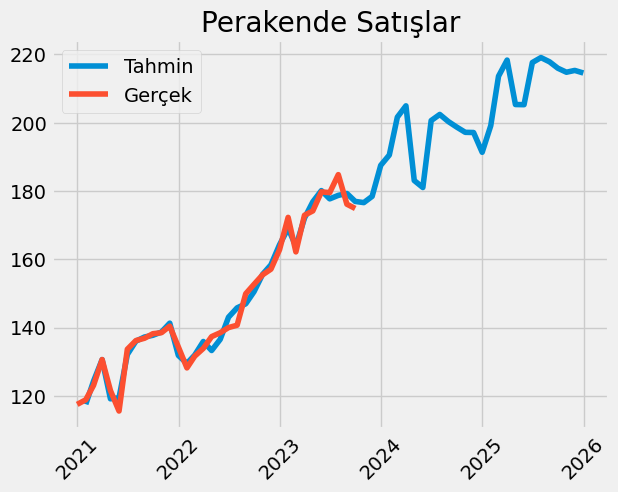

In [636]:
plt.title("Perakende Satışlar")
plt.plot(predictions["yhat"][-60:],label="Tahmin")
plt.plot(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][131:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [637]:
perakendetahmin=(predictions["yhat"][-28:].pct_change(periods=1)*100).dropna()
perakendetahmin

ds
2023-10-31    -0.198150
2023-11-30     1.033406
2023-12-31     5.092513
2024-01-31     1.614187
2024-02-29     5.821133
2024-03-31     1.644104
2024-04-30   -10.673696
2024-05-31    -1.121014
2024-06-30    10.832184
2024-07-31     0.895907
2024-08-31    -1.028484
2024-09-30    -0.804435
2024-10-31    -0.776320
2024-11-30    -0.028461
2024-12-31    -2.934550
2025-01-31     4.074081
2025-02-28     7.271980
2025-03-31     2.211173
2025-04-30    -5.961543
2025-05-31    -0.023782
2025-06-30     6.015436
2025-07-31     0.667099
2025-08-31    -0.566781
2025-09-30    -0.861429
2025-10-31    -0.543977
2025-11-30     0.246907
2025-12-31    -0.349946
Name: yhat, dtype: float64

In [638]:
motorintahmin=pd.DataFrame((1+(((usdtahmin1[2:].pct_change(periods=1)*100).dropna())/100)).values*(1+(((brenttahmin1[:-1].pct_change(periods=1)*100).dropna())/100)).values)
motorintahmin.columns=["Motorin"]
motorintahmin=motorintahmin.set_index(pd.date_range(start="2023-11-30",periods=len(motorintahmin),freq="1M"))
motorintahmin.iloc[0,0]=(motorin.pct_change(periods=1)*100).iloc[-1,0]
motorintahmin[1:]=((motorintahmin[1:])-1)*100
motorintahmin

,Motorin
2023-11-30,-3.136247
2023-12-31,-4.027117
2024-01-31,6.737026
2024-02-29,-4.033748
2024-03-31,1.840370
2024-04-30,14.720000
2024-05-31,7.542310
2024-06-30,-0.642091
2024-07-31,-0.692560
2024-08-31,1.116657


In [639]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=money["Para Arzi"].index
    sn["y"]=money["Para Arzi"].values
    sn["cap"]=100
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=51,freq="M")
    future_dates["cap"]=100
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-51))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=money["Para Arzi"].index\n    sn["y"]=money["Para Arzi"].values\n    sn["cap"]=100\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=51,freq="M")\n    future_dates["cap"]=100\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-51))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=1000)'

In [640]:
#study.best_params

In [641]:
sn=pd.DataFrame()
sn["ds"]=money["Para Arzi"].index
sn["y"]=money["Para Arzi"].values
sn["cap"]=100
prophet=Prophet(changepoint_prior_scale=4.465458778605585,
 changepoint_range=0.8996787920607507,
 growth='linear')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=100
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Bora\AppData\Local\Temp\tmpl87r6lfv\0mxn0kdy.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Bora\AppData\Local\Temp\tmpl87r6lfv\gefbu1tc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Bora\\AppData\\Local\\Programs\\Python\\Python310\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=49031', 'data', 'file=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\0mxn0kdy.json', 'init=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\gefbu1tc.json', 'output', 'file=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\prophet_modelmqf3t2sp\\prophet_model-2023120

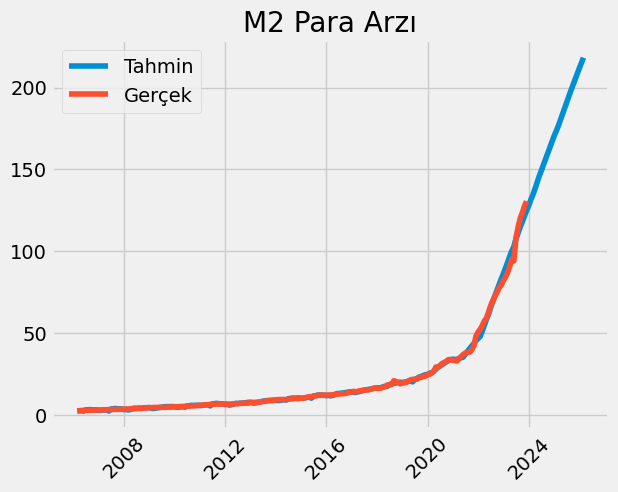

In [642]:
plt.title("M2 Para Arzı")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(money["Para Arzi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [643]:
paraarzitahmin=(predictions["yhat"].pct_change(periods=1)*100).tail(30)
paraarzitahmin

ds
2023-09-30    2.742927
2023-10-31    2.940250
2023-11-30    2.726425
2023-12-31    2.435868
2024-01-31    2.899538
2024-02-29    2.177861
2024-03-31    2.761391
2024-04-30    2.752941
2024-05-31    2.824177
2024-06-30    2.229595
2024-07-31    2.454751
2024-08-31    2.258201
2024-09-30    2.225370
2024-10-31    2.226802
2024-11-30    2.154542
2024-12-31    2.101143
2025-01-31    1.773219
2025-02-28    1.700967
2025-03-31    2.101302
2025-04-30    2.026967
2025-05-31    1.966452
2025-06-30    1.982971
2025-07-31    1.901343
2025-08-31    1.827956
2025-09-30    1.701544
2025-10-31    1.750731
2025-11-30    1.682076
2025-12-31    1.604009
2026-01-31    1.531496
2026-02-28    1.445728
Name: yhat, dtype: float64

In [644]:
paraarzitahmin1 = []
result = money.iloc[-4,0]
for i in range(len(paraarzitahmin)):
    result *= (1 + paraarzitahmin[i] / 100)
    paraarzitahmin1.append(result)

paraarzitahmin1 = np.array(paraarzitahmin1).reshape(-1, 1)
paraarzitahmin1 = pd.DataFrame(paraarzitahmin1)
paraarzitahmin1.columns = ["Para Arzi"]
paraarzitahmin1 = paraarzitahmin1.set_index(pd.date_range(start="2023-09-30", end="2026-03-27", freq="1M"))
paraarzitahmin1.iloc[:2,0]=money.iloc[-3:-1,0]
paraarzitahmin1

,Para Arzi
2023-09-30,123.493114
2023-10-31,127.637895
2023-11-30,130.651971
2023-12-31,133.834480
2024-01-31,137.715062
2024-02-29,140.714305
2024-03-31,144.599977
2024-04-30,148.580730
2024-05-31,152.776912
2024-06-30,156.183219


In [645]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,1.0),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=borc["Borç"].index
    sn["y"]=borc["Borç"].values
    sn["cap"]=100
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=27,freq="M")
    future_dates["cap"]=100
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,1.0),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=borc["Borç"].index\n    sn["y"]=borc["Borç"].values\n    sn["cap"]=100\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=27,freq="M")\n    future_dates["cap"]=100\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=2000)'

In [646]:
#study.best_params

In [647]:
sn=pd.DataFrame()
sn["ds"]=borc["Borç"].index
sn["y"]=borc["Borç"].values
sn["cap"]=100
prophet=Prophet(changepoint_prior_scale=6.640430210557363,
 changepoint_range=0.9191998720423614,
 growth='linear')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=100
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Bora\AppData\Local\Temp\tmpl87r6lfv\9nf9c5k2.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Bora\AppData\Local\Temp\tmpl87r6lfv\4eii_m0h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Bora\\AppData\\Local\\Programs\\Python\\Python310\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=90983', 'data', 'file=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\9nf9c5k2.json', 'init=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\4eii_m0h.json', 'output', 'file=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\prophet_model8d16c3he\\prophet_model-2023120

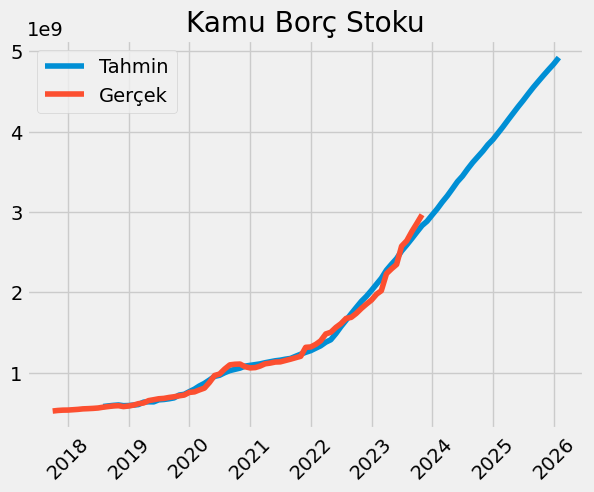

In [648]:
plt.title("Kamu Borç Stoku")
plt.plot(predictions["yhat"][150:],label="Tahmin")
plt.plot(borc["Borç"][140:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [649]:
borctahmin=(predictions["yhat"].pct_change(periods=1)*100).tail(27)
borctahmin

ds
2023-11-30    1.883543
2023-12-31    2.736763
2024-01-31    2.617891
2024-02-29    2.666241
2024-03-31    2.527586
2024-04-30    2.671336
2024-05-31    2.764717
2024-06-30    2.029508
2024-07-31    2.563505
2024-08-31    2.324508
2024-09-30    1.934602
2024-10-31    1.944401
2024-11-30    2.097859
2024-12-31    1.723105
2025-01-31    2.081369
2025-02-28    1.846078
2025-03-31    2.130799
2025-04-30    1.968873
2025-05-31    1.988258
2025-06-30    1.787297
2025-07-31    1.919915
2025-08-31    1.820722
2025-09-30    1.612128
2025-10-31    1.617475
2025-11-30    1.496293
2025-12-31    1.473541
2026-01-31    1.653247
Name: yhat, dtype: float64

In [650]:
borctahmin1 = []
result = borc.iloc[-1,0]
for i in range(len(borctahmin)):
    result *= (1 + borctahmin[i] / 100)
    borctahmin1.append(result)

borctahmin1 = np.array(borctahmin1).reshape(-1, 1)
borctahmin1 = pd.DataFrame(borctahmin1)
borctahmin1.columns = ["Borç"]
borctahmin1 = borctahmin1.set_index(pd.date_range(start="2023-11-30", end="2026-02-27", freq="1M"))
row=pd.DataFrame({"Borç":borc.iloc[-4:,0]},index=pd.date_range(start="2023-07-30",periods=4,freq="1M"))
borctahmin1=pd.concat([row,borctahmin1],axis=0)
borctahmin1

,Borç
2023-07-31,2.643068e+09
2023-08-31,2.758965e+09
2023-09-30,2.859751e+09
2023-10-31,2.966763e+09
2023-11-30,3.022643e+09
2023-12-31,3.105365e+09
2024-01-31,3.186661e+09
2024-02-29,3.271625e+09
2024-03-31,3.354318e+09
2024-04-30,3.443923e+09


In [651]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,1.0),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df3["Kredi"].index
    sn["y"]=df3["Kredi"].values
    sn["cap"]=100
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=27,freq="M")
    future_dates["cap"]=100
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,1.0),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df3["Kredi"].index\n    sn["y"]=df3["Kredi"].values\n    sn["cap"]=100\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=27,freq="M")\n    future_dates["cap"]=100\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=2000)'

In [652]:
#study.best_params

In [653]:
sn=pd.DataFrame()
sn["ds"]=df3["Kredi"].index
sn["y"]=df3["Kredi"].values
sn["cap"]=100
prophet=Prophet(changepoint_prior_scale=7.34998226814572,
 changepoint_range=0.9866543753451638,
 growth='linear')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=100
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Bora\AppData\Local\Temp\tmpl87r6lfv\cr7bz90_.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Bora\AppData\Local\Temp\tmpl87r6lfv\jdtltpiw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Bora\\AppData\\Local\\Programs\\Python\\Python310\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=16354', 'data', 'file=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\cr7bz90_.json', 'init=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\jdtltpiw.json', 'output', 'file=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\prophet_model157do9r5\\prophet_model-2023120

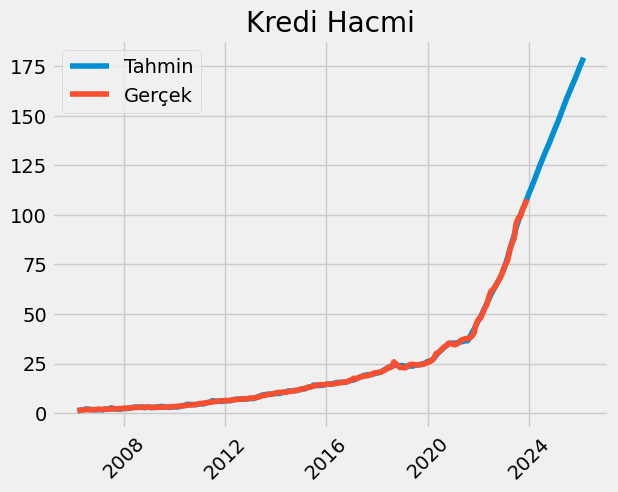

In [654]:
plt.title("Kredi Hacmi")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(df3["Kredi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [655]:
kreditahmin=predictions["yhat"].tail(30)
kreditahmin[:3]=df3.iloc[-3:,0]
kreditahmin=pd.DataFrame(kreditahmin)
kreditahmin.columns=["Kredi"]
kreditahmin=kreditahmin.set_index(pd.date_range(start="2023-09-30",periods=len(kreditahmin),freq="1M"))
kreditahmin

,Kredi
2023-09-30,102.582870
2023-10-31,104.793503
2023-11-30,107.866144
2023-12-31,110.747146
2024-01-31,113.266284
2024-02-29,115.774377
2024-03-31,118.535650
2024-04-30,121.435407
2024-05-31,124.332913
2024-06-30,126.841730


In [656]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,1.0),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=m3["M3 Para Arzi"].index
    sn["y"]=m3["M3 Para Arzi"].values
    sn["cap"]=100
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=27,freq="M")
    future_dates["cap"]=100
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,1.0),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=m3["M3 Para Arzi"].index\n    sn["y"]=m3["M3 Para Arzi"].values\n    sn["cap"]=100\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=27,freq="M")\n    future_dates["cap"]=100\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=2000)'

In [657]:
#study.best_params

In [658]:
sn=pd.DataFrame()
sn["ds"]=m3["M3 Para Arzi"].index
sn["y"]=m3["M3 Para Arzi"].values
sn["cap"]=100
prophet=Prophet(changepoint_prior_scale=8.349018793181163,
 changepoint_range=0.9998797288182553,
 growth='linear')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=100
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Bora\AppData\Local\Temp\tmpl87r6lfv\dn0c13mi.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Bora\AppData\Local\Temp\tmpl87r6lfv\42_a2m_d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Bora\\AppData\\Local\\Programs\\Python\\Python310\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=78059', 'data', 'file=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\dn0c13mi.json', 'init=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\42_a2m_d.json', 'output', 'file=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\prophet_models71vxv32\\prophet_model-2023120

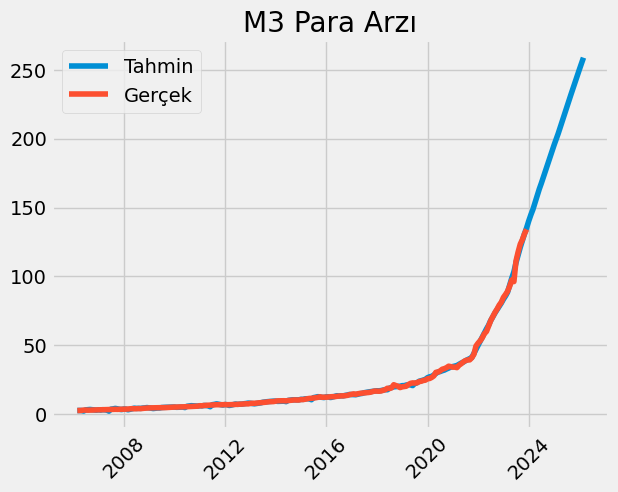

In [659]:
plt.title("M3 Para Arzı")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(m3["M3 Para Arzi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [660]:
m3tahmin=predictions["yhat"].tail(30)
m3tahmin[:3]=m3.iloc[-3:,0]
m3tahmin=pd.DataFrame(m3tahmin)
m3tahmin.columns=["M3"]
m3tahmin=m3tahmin.set_index(pd.date_range(start="2023-09-30",periods=len(kreditahmin),freq="1M"))
m3tahmin

,M3
2023-09-30,126.660411
2023-10-31,130.933903
2023-11-30,134.158381
2023-12-31,140.232633
2024-01-31,144.721396
2024-02-29,148.516007
2024-03-31,153.448476
2024-04-30,158.312950
2024-05-31,163.354211
2024-06-30,167.601338


In [661]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,1.0),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=sanayi["Sanayi"].index
    sn["y"]=sanayi["Sanayi"].values
    sn["cap"]=100
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=27,freq="M")
    future_dates["cap"]=100
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,1.0),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=sanayi["Sanayi"].index\n    sn["y"]=sanayi["Sanayi"].values\n    sn["cap"]=100\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=27,freq="M")\n    future_dates["cap"]=100\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=2000)'

In [662]:
#study.best_params

In [663]:
sn=pd.DataFrame()
sn["ds"]=sanayi["Sanayi"].index
sn["y"]=sanayi["Sanayi"].values
sn["cap"]=100
prophet=Prophet(changepoint_prior_scale=9.211536170339631,
 changepoint_range=0.891187110790083,
 growth='linear')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=100
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Bora\AppData\Local\Temp\tmpl87r6lfv\dxx9k6ul.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Bora\AppData\Local\Temp\tmpl87r6lfv\tl1kbnko.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Bora\\AppData\\Local\\Programs\\Python\\Python310\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=98588', 'data', 'file=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\dxx9k6ul.json', 'init=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\tl1kbnko.json', 'output', 'file=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\prophet_model300kqucw\\prophet_model-2023120

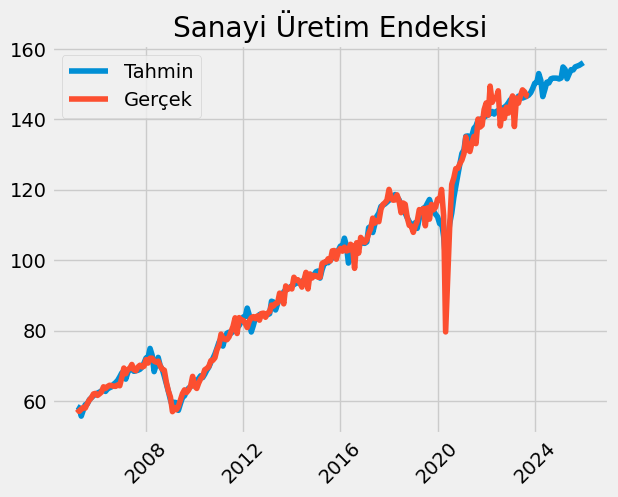

In [664]:
plt.title("Sanayi Üretim Endeksi")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(sanayi["Sanayi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [665]:
sanayitahmin=predictions["yhat"].tail(27)
sanayitahmin=pd.DataFrame(sanayitahmin)
sanayitahmin.columns=["Sanayi"]
sanayitahmin=sanayitahmin.set_index(pd.date_range(start="2023-10-31",periods=len(sanayitahmin),freq="1M"))
sanayitahmin

,Sanayi
2023-10-31,147.549780
2023-11-30,148.746355
2023-12-31,150.218248
2024-01-31,150.476348
2024-02-29,152.980863
2024-03-31,151.088129
2024-04-30,146.446123
2024-05-31,148.435360
2024-06-30,150.541376
2024-07-31,150.307142


In [666]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,1.0),
                'growth': trial.suggest_categorical('growth', ['logistic'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=redkt["REDKT"].index
    sn["y"]=redkt["REDKT"].values
    sn["cap"]=100
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=27,freq="M")
    future_dates["cap"]=100
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,1.0),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'logistic\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=redkt["REDKT"].index\n    sn["y"]=redkt["REDKT"].values\n    sn["cap"]=100\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=27,freq="M")\n    future_dates["cap"]=100\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=2000)'

In [667]:
#study.best_params

In [668]:
sn=pd.DataFrame()
sn["ds"]=redkt["REDKT"].index
sn["y"]=redkt["REDKT"].values
sn["cap"]=200
prophet=Prophet(changepoint_prior_scale=4.998474885835357,
 changepoint_range=0.8719913329652468,
 growth='logistic')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=200
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Bora\AppData\Local\Temp\tmpl87r6lfv\dg8xlmon.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Bora\AppData\Local\Temp\tmpl87r6lfv\8t24x8re.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Bora\\AppData\\Local\\Programs\\Python\\Python310\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=43586', 'data', 'file=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\dg8xlmon.json', 'init=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\8t24x8re.json', 'output', 'file=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\prophet_modelprncdz7w\\prophet_model-2023120

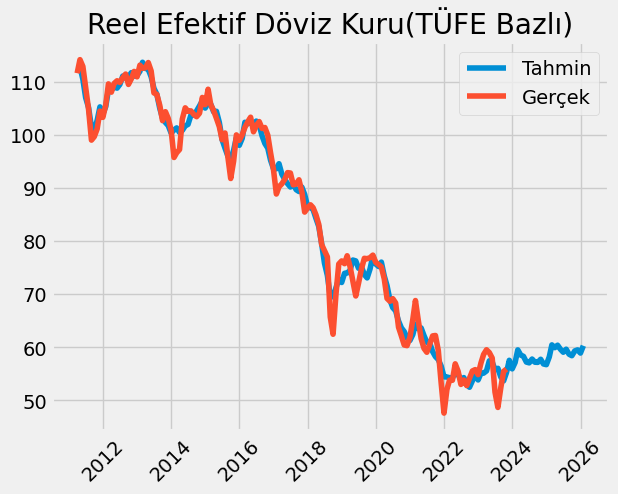

In [669]:
plt.title("Reel Efektif Döviz Kuru(TÜFE Bazlı)")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(redkt["REDKT"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [670]:
redkttahmin=predictions["yhat"].tail(28)
redkttahmin=pd.DataFrame(redkttahmin)
redkttahmin.columns=["REDKT"]
redkttahmin=redkttahmin.set_index(pd.date_range(start="2023-10-31",periods=len(redkttahmin),freq="1M"))
redkttahmin

,REDKT
2023-10-31,55.257962
2023-11-30,57.555282
2023-12-31,55.948002
2024-01-31,57.130925
2024-02-29,59.515766
2024-03-31,58.554731
2024-04-30,58.294568
2024-05-31,57.222623
2024-06-30,57.077329
2024-07-31,57.795543


In [671]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,1.0),
                'growth': trial.suggest_categorical('growth', ['logistic','linear'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=redk["REDK"].index
    sn["y"]=redk["REDK"].values
    sn["cap"]=100
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=27,freq="M")
    future_dates["cap"]=100
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,1.0),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'logistic\',\'linear\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=redk["REDK"].index\n    sn["y"]=redk["REDK"].values\n    sn["cap"]=100\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=27,freq="M")\n    future_dates["cap"]=100\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=2000)'

In [672]:
#study.best_params

In [673]:
sn=pd.DataFrame()
sn["ds"]=redk["REDK"].index
sn["y"]=redk["REDK"].values
sn["cap"]=165
prophet=Prophet(changepoint_prior_scale=4.697452368413781,
 changepoint_range=0.9845493532029166,
 growth='logistic')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=165
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Bora\AppData\Local\Temp\tmpl87r6lfv\ybnaaxqi.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Bora\AppData\Local\Temp\tmpl87r6lfv\0pqw5eix.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Bora\\AppData\\Local\\Programs\\Python\\Python310\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=80263', 'data', 'file=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\ybnaaxqi.json', 'init=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\0pqw5eix.json', 'output', 'file=C:\\Users\\Bora\\AppData\\Local\\Temp\\tmpl87r6lfv\\prophet_model3ld9xe4c\\prophet_model-2023120

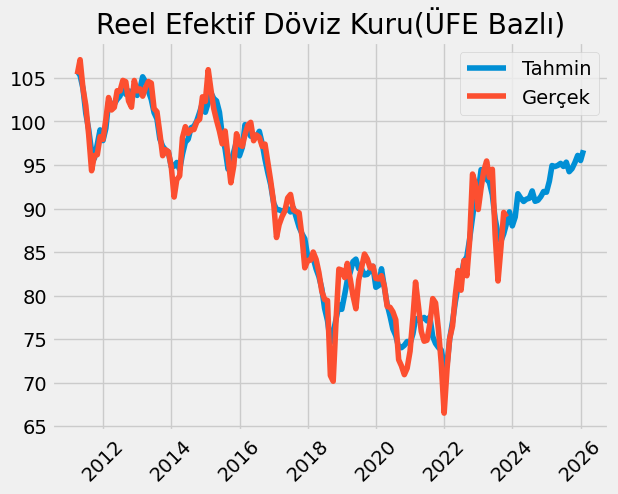

In [674]:
plt.title("Reel Efektif Döviz Kuru(ÜFE Bazlı)")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(redk["REDK"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [675]:
redktahmin=predictions["yhat"].tail(28)
redktahmin=pd.DataFrame(redktahmin)
redktahmin.columns=["REDK"]
redktahmin=redktahmin.set_index(pd.date_range(start="2023-10-31",periods=len(redkttahmin),freq="1M"))
redktahmin

,REDK
2023-10-31,88.331233
2023-11-30,89.614913
2023-12-31,88.006828
2024-01-31,89.026586
2024-02-29,91.698703
2024-03-31,91.184517
2024-04-30,90.812384
2024-05-31,91.083325
2024-06-30,91.176576
2024-07-31,92.020389


In [676]:
motorintahmin

,Motorin
2023-11-30,-3.136247
2023-12-31,-4.027117
2024-01-31,6.737026
2024-02-29,-4.033748
2024-03-31,1.840370
2024-04-30,14.720000
2024-05-31,7.542310
2024-06-30,-0.642091
2024-07-31,-0.692560
2024-08-31,1.116657


In [677]:
import statsmodels.api as sm
tahmindf=pd.DataFrame()
tahmindf=pd.concat([usdtahmin1["USD/TL"].rolling(3).mean(),paraarzitahmin1["Para Arzi"].shift(1),sanayitahmin["Sanayi"],kreditahmin.rolling(2).mean(),redkttahmin["REDKT"],redktahmin["REDK"],m3tahmin.shift(1),borctahmin1.shift(1)],axis=1)
tahmindf=tahmindf.pct_change(periods=1)*100
#tahmindf=tahmindf.dropna(axis=0)
tahmindf["Enflasyon Belirsizliği"]=enfbelirsizliktahmin1["Enflasyon Belirsizliği"]
tahmindf["Zam"]=zamtahmin["Zam"]
tahmindf["Motorin"]=motorintahmin["Motorin"]
tahmindf["Kredi Faizi"]=kfaiztahmin["Kredi Faizi"]
tahmindf["Mevduat Faizi"]=mfaiztahmin["Mevduat Faizi"]
tahmindf["İşsizlik"]=issizliktahmin
#tahmindf["Politika Faizi"]=faiztahmin["Faiz"]
tahmindf["Perakende"]=perakendetahmin



tahmindf["Şok"]=0
tahmindf=tahmindf.iloc[:19]
tahmindf["Politika Faizi"]=[36,40,42.5,45,45,45,45,45,45,45,45,45,45,42.5,40,40,37.5,35,35]
tahmindf=tahmindf[['USD/TL', 'Motorin','Perakende', 'Kredi Faizi', 'Zam','Sanayi',
       'Enflasyon Belirsizliği', 'Para Arzi', 'Borç', 'Kredi', 'Mevduat Faizi','Şok','M3','REDKT','REDK','İşsizlik','Politika Faizi']]

tahmindf.columns=["USD/TL","Motorin","Perakende Satış","Kredi Faizi","Zam","Sanayi","Enflasyon Belirsizliği",'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi','Şok','M3','REDKT','REDK','İşsizlik','Politika Faizi']
tahmindf=tahmindf.dropna(axis=0)
tahmindf.iloc[0,10]=46.07


tahmindf.iloc[0,13:15]=[0.60,-0.30]

tahmindf

,USD/TL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,Şok,M3,REDKT,REDK,İşsizlik,Politika Faizi
2023-11-30,2.001541,-3.136247,1.033406,58.655000,0.0,0.810964,4.490000,3.356285,3.741984,2.547674,46.070000,0,3.373976,0.600000,-0.300000,9.020789,45.0
2023-12-31,3.331060,-4.027117,5.092513,58.050804,0.0,0.989532,4.802205,2.361427,1.883543,2.799611,46.895208,0,2.462676,-2.792584,-1.794439,9.047010,45.0
2024-01-31,3.252865,6.737026,1.614187,58.243736,45.0,0.171816,5.029205,2.435868,2.736763,2.470179,48.122917,0,4.527672,2.114326,1.158725,9.091588,45.0
2024-02-29,2.729843,-4.033748,5.821133,58.551302,0.0,1.664391,4.548808,2.899538,2.617891,2.244165,49.350625,0,3.200941,4.174343,3.001482,9.152629,45.0
2024-03-31,2.481262,1.840370,1.644104,59.409785,0.0,-1.237236,4.443607,2.177861,2.666241,2.300625,50.578333,0,2.622011,-1.614757,-0.560734,9.220321,45.0
2024-04-30,2.598066,14.720000,-10.673696,60.386403,0.0,-3.072383,4.622889,2.761391,2.527586,2.416042,51.806042,0,3.321170,-0.444307,-0.408110,9.292262,45.0
2024-05-31,3.213287,7.542310,-1.121014,60.370085,0.0,1.358340,4.410014,2.752941,2.671336,2.415818,53.033750,0,3.170103,-1.838843,0.298353,9.368708,45.0
2024-06-30,3.006690,-0.642091,10.832184,61.813906,0.0,1.418810,4.388893,2.824177,2.764717,2.199764,54.261458,0,3.184364,-0.253909,0.102379,9.446114,45.0
2024-07-31,2.738795,-0.692560,0.895907,62.228177,0.0,-0.155594,4.233606,2.229595,2.029508,2.072975,55.489167,0,2.599950,1.258318,0.925472,9.523187,45.0
2024-08-31,2.665517,1.116657,-1.028484,62.126429,0.0,0.790256,4.137704,2.454751,2.563505,2.092721,56.716875,0,2.797617,-1.043743,-1.293000,9.599515,42.5


In [678]:
cor_matrix=data.corr()


In [679]:
cor_matrix["TÜFE"].sort_values(ascending=False)

TÜFE                      1.000000
USD/TL                    0.724721
Motorin                   0.718312
ParaArzi                  0.678612
M3                        0.670119
Enflasyon Belirsizliği    0.622137
Kredi Faizi               0.531337
Kredi                     0.520359
Şok                       0.449432
Borç                      0.447182
Mevduat Faizi             0.441591
Zam                       0.410035
Politika Faizi            0.215310
REDK                     -0.000213
REDKT                    -0.024862
Sanayi                   -0.047965
Perakende Satış          -0.116436
İşsizlik                 -0.187390
Name: TÜFE, dtype: float64

In [680]:
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'İşsizlik', 'Politika Faizi']
X = data[features]
y=data["TÜFE"]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=100000, tol=1e-6))
reg.fit(X, y)

tüfetahmin1 = []
result = 1749.04
sgdtahmin=reg.predict(tahmindf[features])
for i in range(len(sgdtahmin)):
    result *= (1 + sgdtahmin[i] / 100)
    tüfetahmin1.append(result)

tüfetahmin1 = np.array(tüfetahmin1).reshape(-1, 1)
tüfetahmin1 = pd.DataFrame(tüfetahmin1)
tüfetahmin1.columns = ["SGD Regressor"]
tüfetahmin1 = tüfetahmin1.set_index(pd.date_range(start="2023-11-30", end="2025-02-27", freq="1M"))
tüfetahmin1

,SGD Regressor
2023-11-30,1785.933033
2023-12-31,1815.559873
2024-01-31,1921.107836
2024-02-29,1950.617079
2024-03-31,2005.551594
2024-04-30,2127.724175
2024-05-31,2213.724553
2024-06-30,2249.354674
2024-07-31,2305.000415
2024-08-31,2372.467786


In [681]:
features=['Motorin', 'USD/TL','ParaArzi','Enflasyon Belirsizliği','Kredi Faizi','Kredi','Zam']


X= data[features]
model=LinearRegression()
model.fit(X, y)

tüfetahmin2 = []
result = 1749.04
lineartahmin = model.predict(np.array(tahmindf[features]))
lineartahmin=lineartahmin.ravel()
for i in range(len(lineartahmin)):
    result *= (1 + lineartahmin[i] / 100)
    tüfetahmin2.append(result)

tüfetahmin2 = np.array(tüfetahmin2).reshape(-1, 1)
tüfetahmin2 = pd.DataFrame(tüfetahmin2)
tüfetahmin2.columns = ["Linear Regression"]
tüfetahmin2 = tüfetahmin2.set_index(pd.date_range(start="2023-11-30", end="2025-02-27", freq="1M"))
tüfetahmin2


,Linear Regression
2023-11-30,1791.590999
2023-12-31,1835.868063
2024-01-31,1937.662968
2024-02-29,1984.530077
2024-03-31,2041.179666
2024-04-30,2129.044612
2024-05-31,2206.995496
2024-06-30,2269.840354
2024-07-31,2330.886074
2024-08-31,2397.842420


In [682]:
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Enflasyon Belirsizliği', 'Politika Faizi','USD/TL']


X = data[features]
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X,y)


tüfetahmin5 = []
result = 1749.04
lassotahmin=reg.predict(tahmindf[features])
for i in range(len(lassotahmin)):
    result *= (1 + lassotahmin[i] / 100)
    tüfetahmin5.append(result)

tüfetahmin5 = np.array(tüfetahmin5).reshape(-1, 1)
tüfetahmin5 = pd.DataFrame(tüfetahmin5)
tüfetahmin5.columns = ["Lasso Regression"]
tüfetahmin5 = tüfetahmin5.set_index(pd.date_range(start="2023-11-30", end="2025-02-27", freq="1M"))
tüfetahmin5

,Lasso Regression
2023-11-30,1785.255551
2023-12-31,1824.144576
2024-01-31,1925.881205
2024-02-29,1963.889909
2024-03-31,2017.033347
2024-04-30,2110.660356
2024-05-31,2186.781350
2024-06-30,2236.041961
2024-07-31,2292.456086
2024-08-31,2355.570172


In [683]:
features=['USD/TL','Motorin','Enflasyon Belirsizliği','ParaArzi','M3','Kredi Faizi','Zam']



X = data[features]
y=data["TÜFE"]
reg = linear_model.Lars(random_state=0)
reg.fit(X,y)



tüfetahmin6 = []
result = 1749.04
larstahmin=reg.predict(tahmindf[features])
for i in range(len(larstahmin)):
    result *= (1 + larstahmin[i] / 100)
    tüfetahmin6.append(result)

tüfetahmin6 = np.array(tüfetahmin6).reshape(-1, 1)
tüfetahmin6 = pd.DataFrame(tüfetahmin6)
tüfetahmin6.columns = ["Lars Regression"]
tüfetahmin6 = tüfetahmin6.set_index(pd.date_range(start="2023-11-30", end="2025-02-27", freq="1M"))
tüfetahmin6


,Lars Regression
2023-11-30,1793.655497
2023-12-31,1839.377559
2024-01-31,1929.939408
2024-02-29,1976.733991
2024-03-31,2032.325156
2024-04-30,2117.965343
2024-05-31,2194.703883
2024-06-30,2257.025891
2024-07-31,2317.550568
2024-08-31,2384.164189


In [684]:
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği',  'Politika Faizi']

X = data[features]
y=data["TÜFE"]
krr = KernelRidge()
krr.fit(X, y)

tüfetahmin7 = []
result = 1749.04
krrtahmin=krr.predict(tahmindf[features])
for i in range(len(krrtahmin)):
    result *= (1 + krrtahmin[i] / 100)
    tüfetahmin7.append(result)

tüfetahmin7 = np.array(tüfetahmin7).reshape(-1, 1)
tüfetahmin7 = pd.DataFrame(tüfetahmin7)
tüfetahmin7.columns = ["Kernel Regression"]
tüfetahmin7 = tüfetahmin7.set_index(pd.date_range(start="2023-11-30", end="2025-02-27", freq="1M"))
tüfetahmin7

,Kernel Regression
2023-11-30,1793.757574
2023-12-31,1831.473209
2024-01-31,1945.633267
2024-02-29,1984.394905
2024-03-31,2048.917350
2024-04-30,2181.887059
2024-05-31,2279.741925
2024-06-30,2327.493084
2024-07-31,2396.483341
2024-08-31,2478.060187


In [685]:
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'İşsizlik', 'Politika Faizi','USD/TL']



X = data[features]
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel)
y=data["TÜFE"]
gpr.fit(X, y) 


tüfe = 1749.04  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin8 = []
gaustahmin=gpr.predict(tahmindf[features])
gaustahmin=1+(gaustahmin/100)
for elem in gaustahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin8.append(tüfe)
tüfetahmin8=pd.DataFrame(tüfetahmin8)
tüfetahmin8=tüfetahmin8.set_index(pd.date_range(start="2023-11-30",end="2025-02-27",freq="1M"))
tüfetahmin8.columns=["Gaussian Regression"]

tüfetahmin8
        

,Gaussian Regression
2023-11-30,1784.781709
2023-12-31,1822.652837
2024-01-31,1923.992197
2024-02-29,1960.637123
2024-03-31,2012.445298
2024-04-30,2106.742090
2024-05-31,2182.358543
2024-06-30,2228.207369
2024-07-31,2283.209405
2024-08-31,2345.276272


In [686]:
features=['USD/TL','Motorin','Enflasyon Belirsizliği','ParaArzi','M3','Kredi Faizi','Zam']
X = data[features]
y=data["TÜFE"]
reg = linear_model.BayesianRidge()
reg.fit(X, y)


tüfe = 1749.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin9 = []
bayestahmin=reg.predict(tahmindf[features])
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin9.append(tüfe)
tüfetahmin9=pd.DataFrame(tüfetahmin9)
tüfetahmin9=tüfetahmin9.set_index(pd.date_range(start="2023-11-30",end="2025-02-27",freq="1M"))
tüfetahmin9.columns=["Bayessian Regression"]

tüfetahmin9

,Bayessian Regression
2023-11-30,1795.328163
2023-12-31,1843.103254
2024-01-31,1951.873459
2024-02-29,2003.224218
2024-03-31,2065.276327
2024-04-30,2159.853250
2024-05-31,2244.372429
2024-06-30,2313.777965
2024-07-31,2381.882051
2024-08-31,2456.469278


In [946]:
pred1=pd.DataFrame(pred,index=pd.date_range(start="2023-11-30",periods=15,freq="1M"))
pred1=pred1[0]

In [947]:



tüfetahmin19 = []
result = 1749.04
lstmtahmin=pred1
for i in range(len(lstmtahmin)):
    result *= (1 + lstmtahmin[i] / 100)
    tüfetahmin19.append(result)

tüfetahmin19 = np.array(tüfetahmin19).reshape(-1, 1)
tüfetahmin19 = pd.DataFrame(tüfetahmin19)
tüfetahmin19.columns = ["LSTM"]
tüfetahmin19 = tüfetahmin19.set_index(pd.date_range(start="2023-11-30", end="2025-02-27", freq="1M"))
tüfetahmin19

,LSTM
2023-11-30,1787.798344
2023-12-31,1828.111034
2024-01-31,1899.428605
2024-02-29,1945.235359
2024-03-31,1997.374615
2024-04-30,2088.810483
2024-05-31,2166.820077
2024-06-30,2224.516805
2024-07-31,2280.922395
2024-08-31,2340.208897


In [948]:
tüfetahmin=pd.DataFrame()
tüfetahmin["SGD Regressor"]=tüfetahmin1["SGD Regressor"]
tüfetahmin["Linear Regression"]=tüfetahmin2["Linear Regression"]
tüfetahmin["Lasso Regression"]=tüfetahmin5["Lasso Regression"]
tüfetahmin["Lars Regression"]=tüfetahmin6["Lars Regression"]
tüfetahmin["Kernel Regression"]=tüfetahmin7["Kernel Regression"]
tüfetahmin["Gaussian Regression"]=tüfetahmin8["Gaussian Regression"]
tüfetahmin["Bayessian Regression"]=tüfetahmin9["Bayessian Regression"]
tüfetahmin["LSTM"]=tüfetahmin19["LSTM"]
tüfetahmin["Ortalama"]=tüfetahmin.mean(axis=1)
tüfetahmin

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,LSTM,Ortalama
2023-11-30,1785.933033,1791.590999,1785.255551,1793.655497,1793.757574,1784.781709,1795.328163,1787.798344,1789.762609
2023-12-31,1815.559873,1835.868063,1824.144576,1839.377559,1831.473209,1822.652837,1843.103254,1828.111034,1830.036300
2024-01-31,1921.107836,1937.662968,1925.881205,1929.939408,1945.633267,1923.992197,1951.873459,1899.428605,1929.439868
2024-02-29,1950.617079,1984.530077,1963.889909,1976.733991,1984.394905,1960.637123,2003.224218,1945.235359,1971.157833
2024-03-31,2005.551594,2041.179666,2017.033347,2032.325156,2048.917350,2012.445298,2065.276327,1997.374615,2027.512919
2024-04-30,2127.724175,2129.044612,2110.660356,2117.965343,2181.887059,2106.742090,2159.853250,2088.810483,2127.835921
2024-05-31,2213.724553,2206.995496,2186.781350,2194.703883,2279.741925,2182.358543,2244.372429,2166.820077,2209.437282
2024-06-30,2249.354674,2269.840354,2236.041961,2257.025891,2327.493084,2228.207369,2313.777965,2224.516805,2263.282263
2024-07-31,2305.000415,2330.886074,2292.456086,2317.550568,2396.483341,2283.209405,2381.882051,2280.922395,2323.548792
2024-08-31,2372.467786,2397.842420,2355.570172,2384.164189,2478.060187,2345.276272,2456.469278,2340.208897,2391.257400


In [949]:
dates=pd.date_range('2006-02-01','2023-11-01' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)





dfas1=pd.DataFrame()
dfas1=pd.concat([df["CPI"],tüfetahmin.iloc[:,0]],axis=0)
dfas1=pd.DataFrame(dfas1)
dfas1.columns=[tüfetahmin.columns[0]]

dfas2=pd.DataFrame()
dfas2=pd.concat([df["CPI"],tüfetahmin.iloc[:,1]],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=[tüfetahmin.columns[1]]



dfas4=pd.DataFrame()
dfas4=pd.concat([df["CPI"],tüfetahmin.iloc[:,2]],axis=0)
dfas4=pd.DataFrame(dfas4)
dfas4.columns=[tüfetahmin.columns[2]]

dfas5=pd.DataFrame()
dfas5=pd.concat([df["CPI"],tüfetahmin.iloc[:,3]],axis=0)
dfas5=pd.DataFrame(dfas5)
dfas5.columns=[tüfetahmin.columns[3]]

dfas6=pd.DataFrame()
dfas6=pd.concat([df["CPI"],tüfetahmin.iloc[1:,4]],axis=0)
dfas6=pd.DataFrame(dfas6)
dfas6.columns=[tüfetahmin.columns[4]]

dfas7=pd.DataFrame()
dfas7=pd.concat([df["CPI"],tüfetahmin.iloc[1:,5]],axis=0)
dfas7=pd.DataFrame(dfas7)
dfas7.columns=[tüfetahmin.columns[5]]

dfas8=pd.DataFrame()
dfas8=pd.concat([df["CPI"],tüfetahmin.iloc[1:,6]],axis=0)
dfas8=pd.DataFrame(dfas8)
dfas8.columns=[tüfetahmin.columns[6]]

dfas9=pd.DataFrame()
dfas9=pd.concat([df["CPI"],tüfetahmin.iloc[1:,7]],axis=0)
dfas9=pd.DataFrame(dfas9)
dfas9.columns=[tüfetahmin.columns[7]]
'''
dfas10=pd.DataFrame()
dfas10=pd.concat([df["CPI"],tüfetahmin.iloc[1:,8]],axis=0)
dfas10=pd.DataFrame(dfas10)
dfas10.columns=[tüfetahmin.columns[8]]'''





dfas=pd.DataFrame()
dfas=pd.concat([dfas1,dfas2,dfas4,dfas5,dfas6,dfas7,dfas8,dfas9],axis=1)
dfas=dfas.pct_change(periods=12)*100
dfas=dfas.dropna(axis=0)
dfas

df["Enflasyon"]=df["CPI"].pct_change(periods=12)*100
df=df.dropna(axis=0)








In [950]:
row=pd.DataFrame({"SGD Regressor":df.iloc[-1,0],"Lasso Regression":df.iloc[-1,0],"Lars Regression":df.iloc[-1,0],"Gaussian Regression":df.iloc[-1,0],"Kernel Regression":df.iloc[-1,0],"Bayessian Regression":df.iloc[-1,0],"Linear Regression":df.iloc[-1,0],"LSTM":df.iloc[-1,0],"Ortalama":df.iloc[-1,0]},index=pd.date_range(start="2023-10-30",periods=1,freq="1M"))
tüfetahmin=pd.concat([row,tüfetahmin],axis=0)
tüfetahmin.iloc[1,:8]=tüfetahmin.iloc[1,:8]+21
tüfetahmin.iloc[2,:8]=tüfetahmin.iloc[2,:8]+46
tüfetahmin.iloc[3,:8]=tüfetahmin.iloc[3,:8]+50
tüfetahmin.iloc[4,:8]=tüfetahmin.iloc[4,:8]+50
tüfetahmin.iloc[5,:8]=tüfetahmin.iloc[5,:8]+50
tüfetahmin.iloc[6,:8]=tüfetahmin.iloc[6,:8]+50
tüfetahmin.iloc[7,:8]=tüfetahmin.iloc[7,:8]+50
tüfetahmin.iloc[8,:8]=tüfetahmin.iloc[8,:8]+50
tüfetahmin.iloc[9,:8]=tüfetahmin.iloc[9,:8]+50
tüfetahmin.iloc[10,:8]=tüfetahmin.iloc[10,:8]+50
tüfetahmin.iloc[11,:8]=tüfetahmin.iloc[11,:8]+50
tüfetahmin.iloc[12,:8]=tüfetahmin.iloc[12,:8]+50
tüfetahmin.iloc[13,:8]=tüfetahmin.iloc[13,:8]+50
tüfetahmin.iloc[14,:8]=tüfetahmin.iloc[14,:8]+50
tüfetahmin["Ortalama"]=tüfetahmin.mean(axis=1)
tüfetahmin

,SGD Regressor,Lasso Regression,Lars Regression,Gaussian Regression,Kernel Regression,Bayessian Regression,Linear Regression,LSTM,Ortalama
2023-10-31,1749.110000,1749.110000,1749.110000,1749.110000,1749.110000,1749.110000,1749.110000,1749.110000,1749.110000
2023-11-30,1806.933033,1806.255551,1814.655497,1805.781709,1814.757574,1816.328163,1812.590999,1808.798344,1808.429276
2023-12-31,1861.559873,1870.144576,1885.377559,1868.652837,1877.473209,1889.103254,1881.868063,1874.111034,1870.925189
2024-01-31,1971.107836,1975.881205,1979.939408,1973.992197,1995.633267,2001.873459,1987.662968,1949.428605,1973.884313
2024-02-29,2000.617079,2013.889909,2026.733991,2010.637123,2034.394905,2053.224218,2034.530077,1995.235359,2015.602277
2024-03-31,2055.551594,2067.033347,2082.325156,2062.445298,2098.917350,2115.276327,2091.179666,2047.374615,2071.957363
2024-04-30,2177.724175,2160.660356,2167.965343,2156.742090,2231.887059,2209.853250,2179.044612,2138.810483,2172.280366
2024-05-31,2263.724553,2236.781350,2244.703883,2232.358543,2329.741925,2294.372429,2256.995496,2216.820077,2253.881726
2024-06-30,2299.354674,2286.041961,2307.025891,2278.207369,2377.493084,2363.777965,2319.840354,2274.516805,2307.726707
2024-07-31,2355.000415,2342.456086,2367.550568,2333.209405,2446.483341,2431.882051,2380.886074,2330.922395,2367.993236


In [951]:
aylıktahmin=tüfetahmin.pct_change(periods=1)*100
aylıktahmin=aylıktahmin.dropna(axis=0)
aylıktahmin

,SGD Regressor,Lasso Regression,Lars Regression,Gaussian Regression,Kernel Regression,Bayessian Regression,Linear Regression,LSTM,Ortalama
2023-11-30,3.305855,3.267122,3.747363,3.240031,3.753199,3.842992,3.629331,3.412498,3.391398
2023-12-31,3.023180,3.537098,3.897272,3.481657,3.455868,4.006715,3.821991,3.610833,3.455812
2024-01-31,5.884740,5.653928,5.015539,5.637182,6.293568,5.969510,5.621802,4.018843,5.503113
2024-02-29,1.497089,1.923633,2.363435,1.856387,1.942323,2.565135,2.357900,2.349753,2.113496
2024-03-31,2.745879,2.638845,2.742894,2.576704,3.171579,3.022179,2.784407,2.613188,2.795943
2024-04-30,5.943542,4.529536,4.112719,4.572087,6.335157,4.471138,4.201693,4.466006,4.841943
2024-05-31,3.949094,3.523043,3.539657,3.506050,4.384400,3.824651,3.577296,3.647336,3.756484
2024-06-30,1.573960,2.202299,2.776402,2.053829,2.049633,3.025034,2.784448,2.602680,2.388989
2024-07-31,2.420059,2.467764,2.623494,2.414268,2.901807,2.881154,2.631462,2.479893,2.611511
2024-08-31,2.864856,2.694355,2.813609,2.660150,3.334453,3.067058,2.812245,2.543478,2.859324


In [952]:
tüfe = 1749.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin10 = []
orttahmin=aylıktahmin["Ortalama"]
orttahmin=1+(orttahmin/100)
for elem in orttahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin10.append(tüfe)
tüfetahmin10=pd.DataFrame(tüfetahmin10)
tüfetahmin10=tüfetahmin10.set_index(pd.date_range(start="2023-11-30",end="2025-02-27",freq="1M"))
tüfetahmin10.columns=["CPI"]


tüfetahmin11=pd.concat([df["CPI"],tüfetahmin10["CPI"]],axis=0)
tüfetahmin11=pd.DataFrame((tüfetahmin11.pct_change(periods=12)*100).tail(38))

    

In [692]:
tüfe = 1749.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin12 = []
krrtahmin=aylıktahmin["Gaussian Regression"]
krrtahmin=1+(krrtahmin/100)
for elem in krrtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin12.append(tüfe)
tüfetahmin12=pd.DataFrame(tüfetahmin12)
tüfetahmin12=tüfetahmin12.set_index(pd.date_range(start="2023-11-30",end="2025-02-27",freq="1M"))
tüfetahmin12.columns=["CPI"]
tüfetahmin12=pd.concat([df["CPI"],tüfetahmin12["CPI"]],axis=0)
tüfetahmin12=pd.DataFrame((tüfetahmin12.pct_change(periods=12)*100).tail(38))


In [693]:
tüfe = 1749.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin13 = []
bayestahmin=aylıktahmin["SGD Regressor"]
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin13.append(tüfe)
tüfetahmin13=pd.DataFrame(tüfetahmin13)
tüfetahmin13=tüfetahmin13.set_index(pd.date_range(start="2023-11-30",end="2025-02-27",freq="1M"))
tüfetahmin13.columns=["CPI"]
tüfetahmin13=pd.concat([df["CPI"],tüfetahmin13["CPI"]],axis=0)
tüfetahmin13=pd.DataFrame((tüfetahmin13.pct_change(periods=12)*100).tail(38))


In [694]:
tüfe = 1749.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin14 = []
lassotahmin=aylıktahmin["Lasso Regression"]
lassotahmin=1+(lassotahmin/100)
for elem in lassotahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin14.append(tüfe)
tüfetahmin14=pd.DataFrame(tüfetahmin14)
tüfetahmin14=tüfetahmin14.set_index(pd.date_range(start="2023-11-30",end="2025-02-27",freq="1M"))
tüfetahmin14.columns=["CPI"]
tüfetahmin14=pd.concat([df["CPI"],tüfetahmin14["CPI"]],axis=0)
tüfetahmin14=pd.DataFrame((tüfetahmin14.pct_change(periods=12)*100).tail(38))


In [695]:
tüfe = 1749.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin15 = []
larstahmin=aylıktahmin["Lars Regression"]
larstahmin=1+(larstahmin/100)
for elem in larstahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin15.append(tüfe)
tüfetahmin15=pd.DataFrame(tüfetahmin15)
tüfetahmin15=tüfetahmin15.set_index(pd.date_range(start="2023-11-30",end="2025-02-27",freq="1M"))
tüfetahmin15.columns=["CPI"]
tüfetahmin15=pd.concat([df["CPI"],tüfetahmin15["CPI"]],axis=0)
tüfetahmin15=pd.DataFrame((tüfetahmin15.pct_change(periods=12)*100).tail(38))


In [696]:
tüfe = 1749.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin16 = []
kerneltahmin=aylıktahmin["Kernel Regression"]
kerneltahmin=1+(kerneltahmin/100)
for elem in kerneltahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin16.append(tüfe)
tüfetahmin16=pd.DataFrame(tüfetahmin16)
tüfetahmin16=tüfetahmin16.set_index(pd.date_range(start="2023-11-30",end="2025-02-27",freq="1M"))
tüfetahmin16.columns=["CPI"]
tüfetahmin16=pd.concat([df["CPI"],tüfetahmin16["CPI"]],axis=0)
tüfetahmin16=pd.DataFrame((tüfetahmin16.pct_change(periods=12)*100).tail(38))

In [697]:
tüfe = 1749.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin17 = []
bayestahmin=aylıktahmin["Bayessian Regression"]
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin17.append(tüfe)
tüfetahmin17=pd.DataFrame(tüfetahmin17)
tüfetahmin17=tüfetahmin17.set_index(pd.date_range(start="2023-11-30",end="2025-02-27",freq="1M"))
tüfetahmin17.columns=["CPI"]
tüfetahmin17=pd.concat([df["CPI"],tüfetahmin17["CPI"]],axis=0)
tüfetahmin17=pd.DataFrame((tüfetahmin17.pct_change(periods=12)*100).tail(38))

In [698]:
tüfe = 1749.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin18 = []
lineartahmin=aylıktahmin["Linear Regression"]
lineartahmin=1+(lineartahmin/100)
for elem in lineartahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin18.append(tüfe)
tüfetahmin18=pd.DataFrame(tüfetahmin18)
tüfetahmin18=tüfetahmin18.set_index(pd.date_range(start="2023-11-30",end="2025-02-27",freq="1M"))
tüfetahmin18.columns=["CPI"]
tüfetahmin18=pd.concat([df["CPI"],tüfetahmin18["CPI"]],axis=0)
tüfetahmin18=pd.DataFrame((tüfetahmin18.pct_change(periods=12)*100).tail(38))


In [953]:
tüfe = 1749.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin20 = []
lstmtahmin=aylıktahmin["LSTM"]
lstmtahmin=1+(lstmtahmin/100)
for elem in lstmtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin20.append(tüfe)
tüfetahmin20=pd.DataFrame(tüfetahmin20)
tüfetahmin20=tüfetahmin20.set_index(pd.date_range(start="2023-11-30",end="2025-02-27",freq="1M"))
tüfetahmin20.columns=["CPI"]
tüfetahmin20=pd.concat([df["CPI"],tüfetahmin20["CPI"]],axis=0)
tüfetahmin20=pd.DataFrame((tüfetahmin20.pct_change(periods=12)*100).tail(38))

In [954]:
aylık=data["TÜFE"]
aylık=pd.DataFrame(aylık)
ekim=pd.DataFrame({"TÜFE":3.43},index=pd.date_range(start="2023-10-30",periods=1,freq="1M"))
aylık=pd.concat([aylık,ekim],axis=0)
aylık.to_csv('aylık.csv')

In [955]:
aylık1=aylıktahmin
aylık1=aylık1[["Ortalama"]]
aylık1.columns=["TÜFE"]
aylık1=pd.concat([aylık["TÜFE"],aylık1["TÜFE"]])
aylık1=pd.DataFrame(aylık1)
aylık1=aylık1.set_index(pd.date_range(start="2014-01-31",end="2025-02-27",freq="1M"))
aylık1.head(132).to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/aylık.csv')

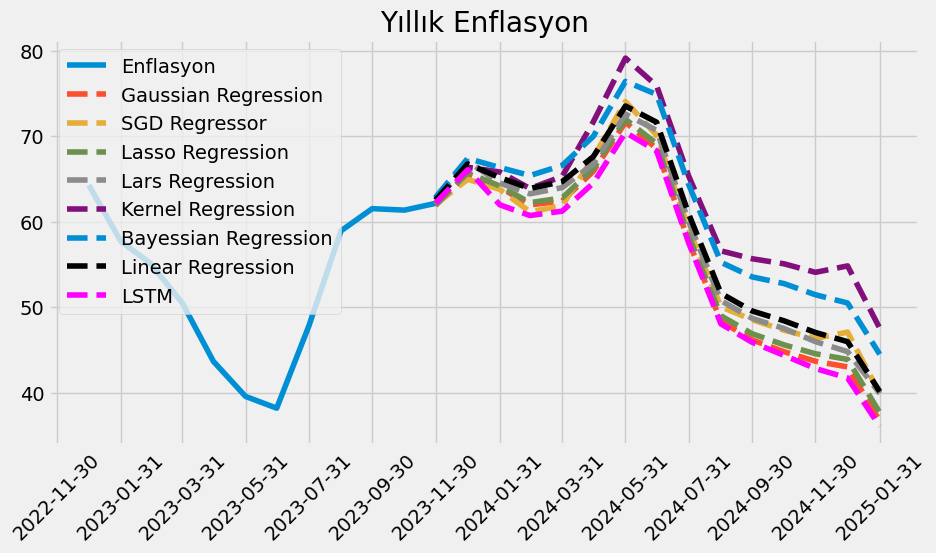

In [956]:
yıllıktahmin=pd.DataFrame()
yıllıktahmin["Ortalama"]=tüfetahmin11["CPI"]
yıllıktahmin["SGD Regressor"]=tüfetahmin13["CPI"]
yıllıktahmin["Gaussian Regression"]=tüfetahmin12["CPI"]
yıllıktahmin["Lasso Regression"]=tüfetahmin14["CPI"]
yıllıktahmin["Lars Regression"]=tüfetahmin15["CPI"]
yıllıktahmin["Kernel Regression"]=tüfetahmin16["CPI"]
yıllıktahmin["Bayessian Regression"]=tüfetahmin17["CPI"]
yıllıktahmin["Linear Regression"]=tüfetahmin18["CPI"]
yıllıktahmin["LSTM"]=tüfetahmin20["CPI"]
plt.figure(figsize=(10,5))
plt.plot(yıllıktahmin["Ortalama"].iloc[12:24],label="Enflasyon")
plt.plot(yıllıktahmin["Gaussian Regression"].iloc[23:],'--',label="Gaussian Regression")
plt.plot(yıllıktahmin["SGD Regressor"].iloc[23:],'--',label="SGD Regressor")
plt.plot(yıllıktahmin["Lasso Regression"].iloc[23:],'--',label="Lasso Regression")
plt.plot(yıllıktahmin["Lars Regression"].iloc[23:],'--',label="Lars Regression")
plt.plot(yıllıktahmin["Kernel Regression"].iloc[23:],'--',label="Kernel Regression")
plt.plot(yıllıktahmin["Bayessian Regression"].iloc[23:],'--',label="Bayessian Regression")
plt.plot(yıllıktahmin["Linear Regression"].iloc[23:],'--',label="Linear Regression",color="black")
plt.plot(yıllıktahmin["LSTM"].iloc[23:],'--',label="LSTM",color="magenta")
plt.legend(loc=0)
plt.xticks(rotation=45)
plt.xticks(pd.date_range(start="2022-11-30",end="2025-02-27",freq="1M")[::2])
plt.title("Yıllık Enflasyon")
plt.show()

In [958]:

df.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/df.csv')

In [959]:
yıllıktahmin["Maksimum"]=yıllıktahmin.iloc[:,1:9].max(axis=1)
yıllıktahmin["Minimum"]=yıllıktahmin.iloc[:,1:9].min(axis=1)
yıllıktahmin.iloc[11:-1].to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/yıllıktahmin.csv')
yıllıktahmin["Ortalama"]=yıllıktahmin.iloc[:,1:9].mean(axis=1)
yıllıktahmin


,Ortalama,SGD Regressor,Gaussian Regression,Lasso Regression,Lars Regression,Kernel Regression,Bayessian Regression,Linear Regression,LSTM,Maksimum,Minimum
2021-12-31,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902
2022-01-31,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824
2022-02-28,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567
2022-03-31,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538
2022-04-30,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070
2022-05-31,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950
2022-06-30,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397
2022-07-31,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053
2022-08-31,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594
2022-09-30,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494


In [960]:
sonu2023=str(yıllıktahmin.iloc[24,0])[:5]
tepe=str(yıllıktahmin.iloc[29,0])[:5]
sonu2024=str(yıllıktahmin.iloc[36,0])[:5]
max=str(yıllıktahmin.iloc[36,-2])[:5]
min=str(yıllıktahmin.iloc[36,-1])[:5]


In [961]:
sonu2024

'46.49'

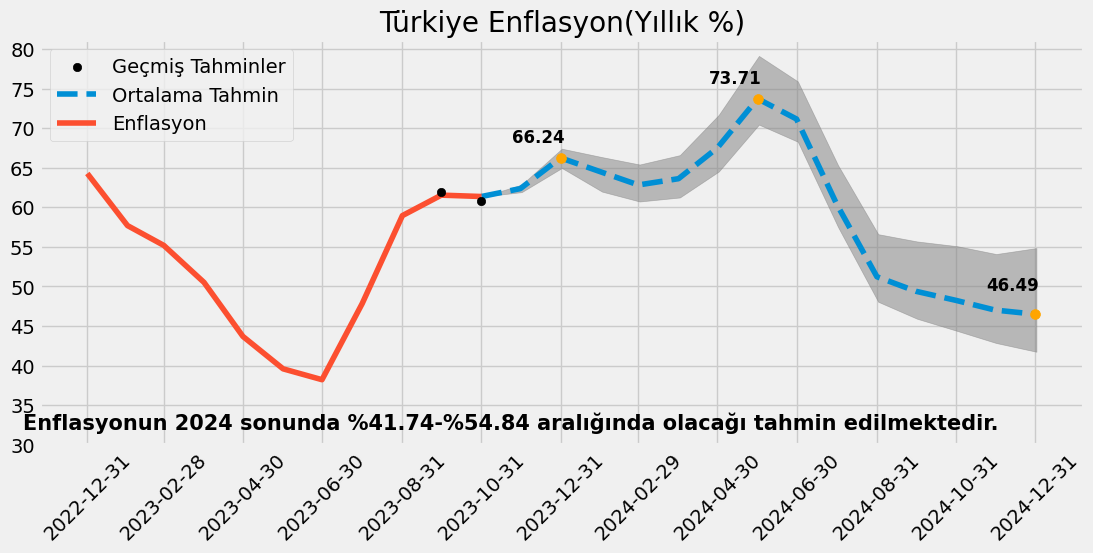

In [962]:
import matplotlib.dates as mdates  # datetime işlevlerini içe aktarın

# ...

plt.style.use('fivethirtyeight')
fig=plt.figure(figsize=(12,5))
plt.scatter(x=yıllıktahmin.index[21:23],y=[61.94,60.84],color='black',zorder=3,label='Geçmiş Tahminler')
plt.scatter(x=yıllıktahmin.index[24],y=yıllıktahmin.iloc[24,0],color='orange',zorder=3,s=50)
plt.scatter(x=yıllıktahmin.index[29],y=yıllıktahmin.iloc[29,0],color='orange',zorder=3,s=50)
plt.scatter(x=yıllıktahmin.index[36],y=yıllıktahmin.iloc[36,0],color='orange',zorder=3,s=50)
#plt.scatter(x=yıllıktahmin.index[36],y=yıllıktahmin.iloc[36,0],color='orange',zorder=3,s=50)
plt.plot(yıllıktahmin["Ortalama"].iloc[22:37],'--',label="Ortalama Tahmin")
plt.plot(yıllıktahmin["Ortalama"].iloc[12:23],label="Enflasyon")
plt.fill_between(yıllıktahmin.iloc[22:39].index.strftime("%Y-%m"), yıllıktahmin["Maksimum"].iloc[22:39].shift(1), yıllıktahmin["Minimum"].iloc[22:39].shift(1), alpha=0.5, color='gray')
# Tarihi ekseni birimlerine dönüştürün
annotation_date = mdates.datestr2num('2024-12')
plt.text(mdates.datestr2num('2024-01'), float(sonu2023)+2, sonu2023, fontsize=12, color='black', horizontalalignment='right',fontweight='bold')
plt.text(mdates.datestr2num('2024-06'), float(tepe)+2, tepe, fontsize=12, color='black', horizontalalignment='right',fontweight='bold')
plt.text(mdates.datestr2num('2025-01'), float(sonu2024)+3, sonu2024, fontsize=12, color='black', horizontalalignment='right',fontweight='bold')
#plt.text(mdates.datestr2num('2025-12'), float(sonra24ay)+3, sonra24ay, fontsize=12, color='black', horizontalalignment='right',fontweight='bold')

plt.text(annotation_date, 32, f"Enflasyonun 2024 sonunda %{min}-%{max} aralığında olacağı tahmin edilmektedir.", fontsize=15, color='black', horizontalalignment='right',fontweight='bold')
plt.xticks(yıllıktahmin.index[12:38:2],rotation=45)
plt.yticks(np.arange(30,85,5))
plt.title("Türkiye Enflasyon(Yıllık %)")
plt.legend(loc=2)
plt.show()
